### Milestone 3  

#### Task 3

In [51]:
%config InlineBackend.figure_format = 'retina'

#import required modules
import pandas as pd
from dataframe_info import DataFrameInfo
import db_utils
from plot import Plotter
from dataframe_utils import DataFrameTransform
from datatransform_utils import DataTransform
import statsmodels.formula.api as smf

In [52]:
# load local loan csv into pandas dataframe
df = db_utils.csv_to_dataframe('loan_payments.csv')
pd.set_option('display.max_columns', None)
df.sample(10)

id  member_id  loan_amount  funded_amount  funded_amount_inv  \
1524   38524814   41238588        21000        21000.0         21000.0000   
51087    439561     531192        18400        18400.0         18275.0000   
14914   8608287   10360110        17000        17000.0         16925.0000   
48882    499499     641139         5000         5000.0          5000.0000   
20873   7174858    8857013         6000         6000.0          6000.0000   
37032    880318    1095277        35000        35000.0         34950.0000   
36407    969613    1190839        12000        12000.0         11692.3357   
15091   8599676   10351190        11650        11650.0         11650.0000   
50235    464609     582432         2000         2000.0          2000.0000   
49249    490988     627202        17000        17000.0         16975.0000   

            term  int_rate  instalment grade sub_grade employment_length  \
1524         NaN     14.31      492.02     C        C4         10+ years   
51087  36 months       NaN      634.35     D        D1         10+ years   
14914  36 months      8.90      539.81     A        A5         10+ years   
48882  36 months      7.14      154.70     A        A3           3 years   
20873        NaN       NaN      200.30     B        B4               NaN   
37032  36 months     15.96     1229.81     C        C5           8 years   
36407  36 months      7.90      375.49     A        A4           3 years   
15091        NaN     14.47      273.93     C        C2         10+ years   
50235  36 months      7.40       62.12     A        A2           3 years   
49249  36 months       NaN      550.55     B        B2            1 year   

      home_ownership  annual_inc verification_status issue_date  loan_status  \
1524        MORTGAGE    142000.0            Verified   Jan-2021      Current   
51087           RENT    121000.0        Not Verified   Sep-2015   Fully Paid   
14914           RENT     50000.0     Source Verified   Nov-2019      Current   
48882       MORTGAGE     58000.0        Not Verified   Apr-2016   Fully Paid   
20873            OWN     28000.0            Verified   Sep-2019      Current   
37032       MORTGAGE    150000.0            Verified   Sep-2017   Fully Paid   
36407           RENT    187000.0            Verified   Oct-2017  Charged Off   
15091       MORTGAGE     65000.0            Verified   Dec-2019   Fully Paid   
50235       MORTGAGE     60000.0        Not Verified   Dec-2015   Fully Paid   
49249       MORTGAGE     83000.0        Not Verified   Mar-2016   Fully Paid   

      payment_plan             purpose    dti  delinq_2yrs  \
1524             n         credit_card   7.62            0   
51087            n      small_business  13.09            0   
14914            n  debt_consolidation  11.74            0   
48882            n               other   4.74            1   
20873            n         credit_card   6.08            0   
37032            n  debt_consolidation  12.23            0   
36407            n  debt_consolidation   4.89            0   
15091            n    home_improvement   3.31            0   
50235            n                 car  10.04            0   
49249            n    home_improvement  16.19            0   

      earliest_credit_line  inq_last_6mths  mths_since_last_delinq  \
1524              Mar-1999               1                    26.0   
51087             Nov-1989               0                     NaN   
14914             Jan-1996               0                     NaN   
48882             Jun-1986               1                    15.0   
20873             Oct-2001               0                     NaN   
37032             Dec-1994               2                     NaN   
36407             Oct-2004               2                     NaN   
15091             Aug-1988               2                     NaN   
50235             Jan-1998               0                     NaN   
49249             Nov-1995               0                     N

### The number of nulls per column in the database given as a count and precentage is:

In [53]:
transform = DataFrameInfo()
missing_data = transform.null_counts(df)
display(missing_data)

There are 54231 records in the database.
The columns that contain nulls are listed below along with their null counts/percentages.


Null_Count  Percentage_of_Nulls
funded_amount                      3007                 5.54
term                               4772                 8.80
int_rate                           5169                 9.53
employment_length                  2118                 3.91
mths_since_last_delinq            31002                57.17
mths_since_last_record            48050                88.60
last_payment_date                    73                 0.13
next_payment_date                 32608                60.13
last_credit_pull_date                 7                 0.01
collections_12_mths_ex_med           51                 0.09
mths_since_last_major_derog       46732                86.17

Below is a plot that visualises the nulls in the dataframe.

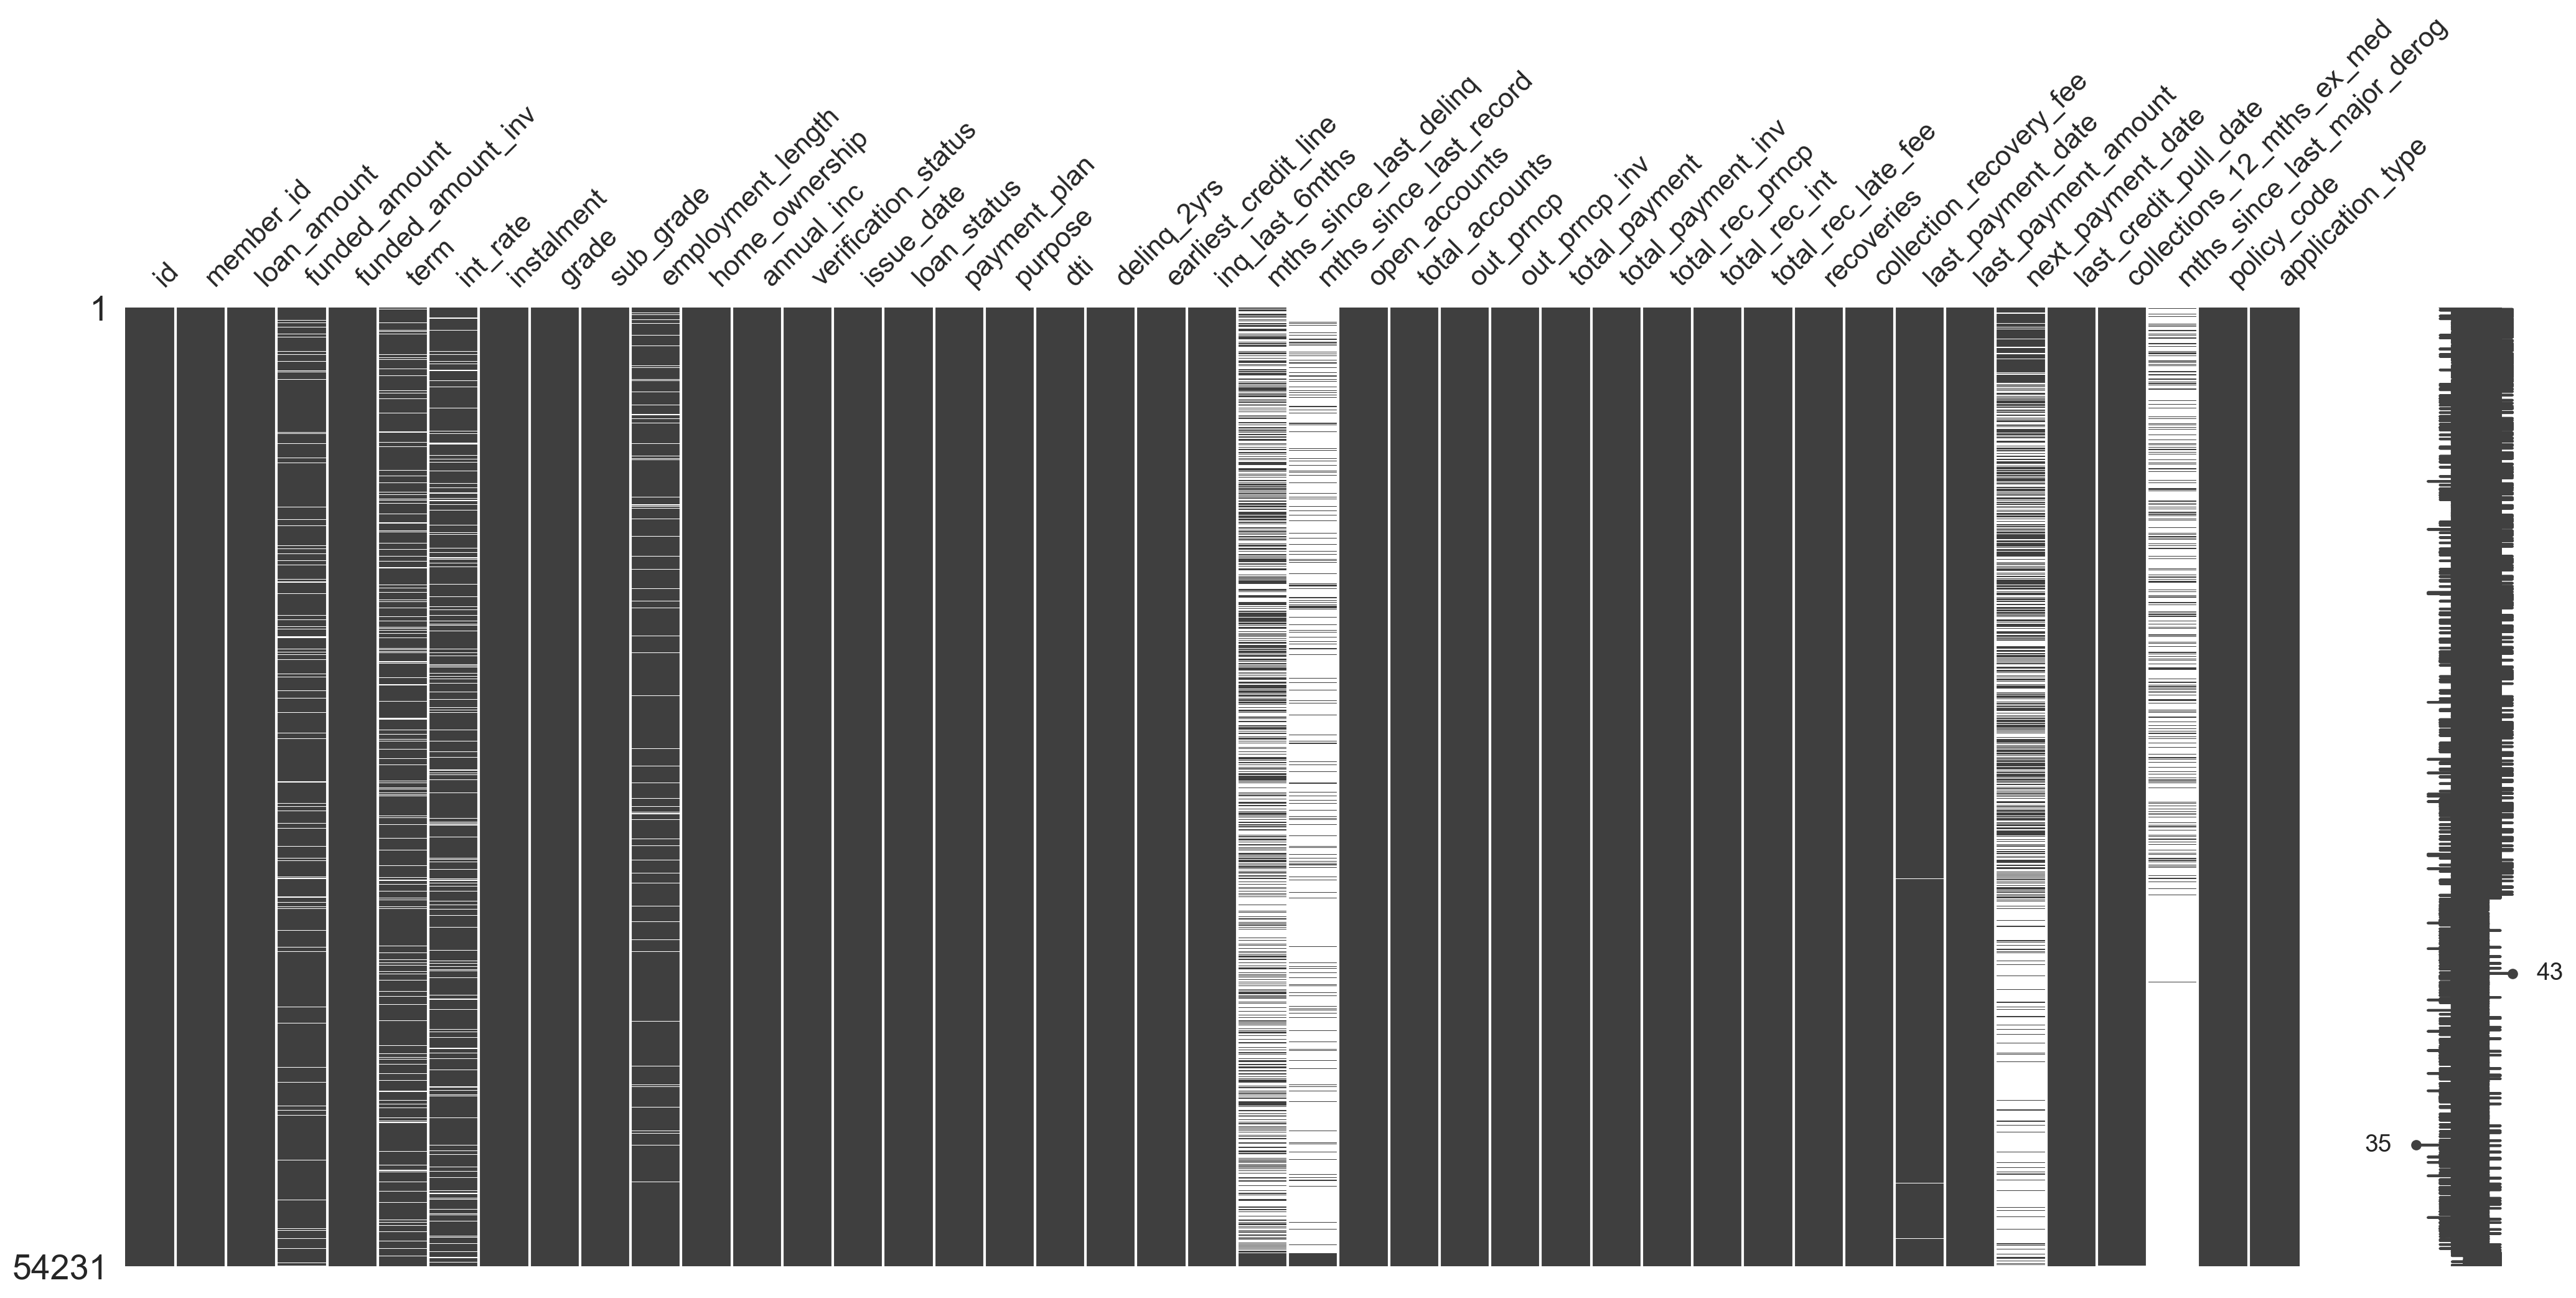

In [54]:
# Visualise plot
plot = Plotter()
plot.plot_missingno(df)

There does not seem to be any descernible pattern in the plot which suggest that the missing data is MCAR or MAR. Let's look at a heatmap for any correlation between missing values.

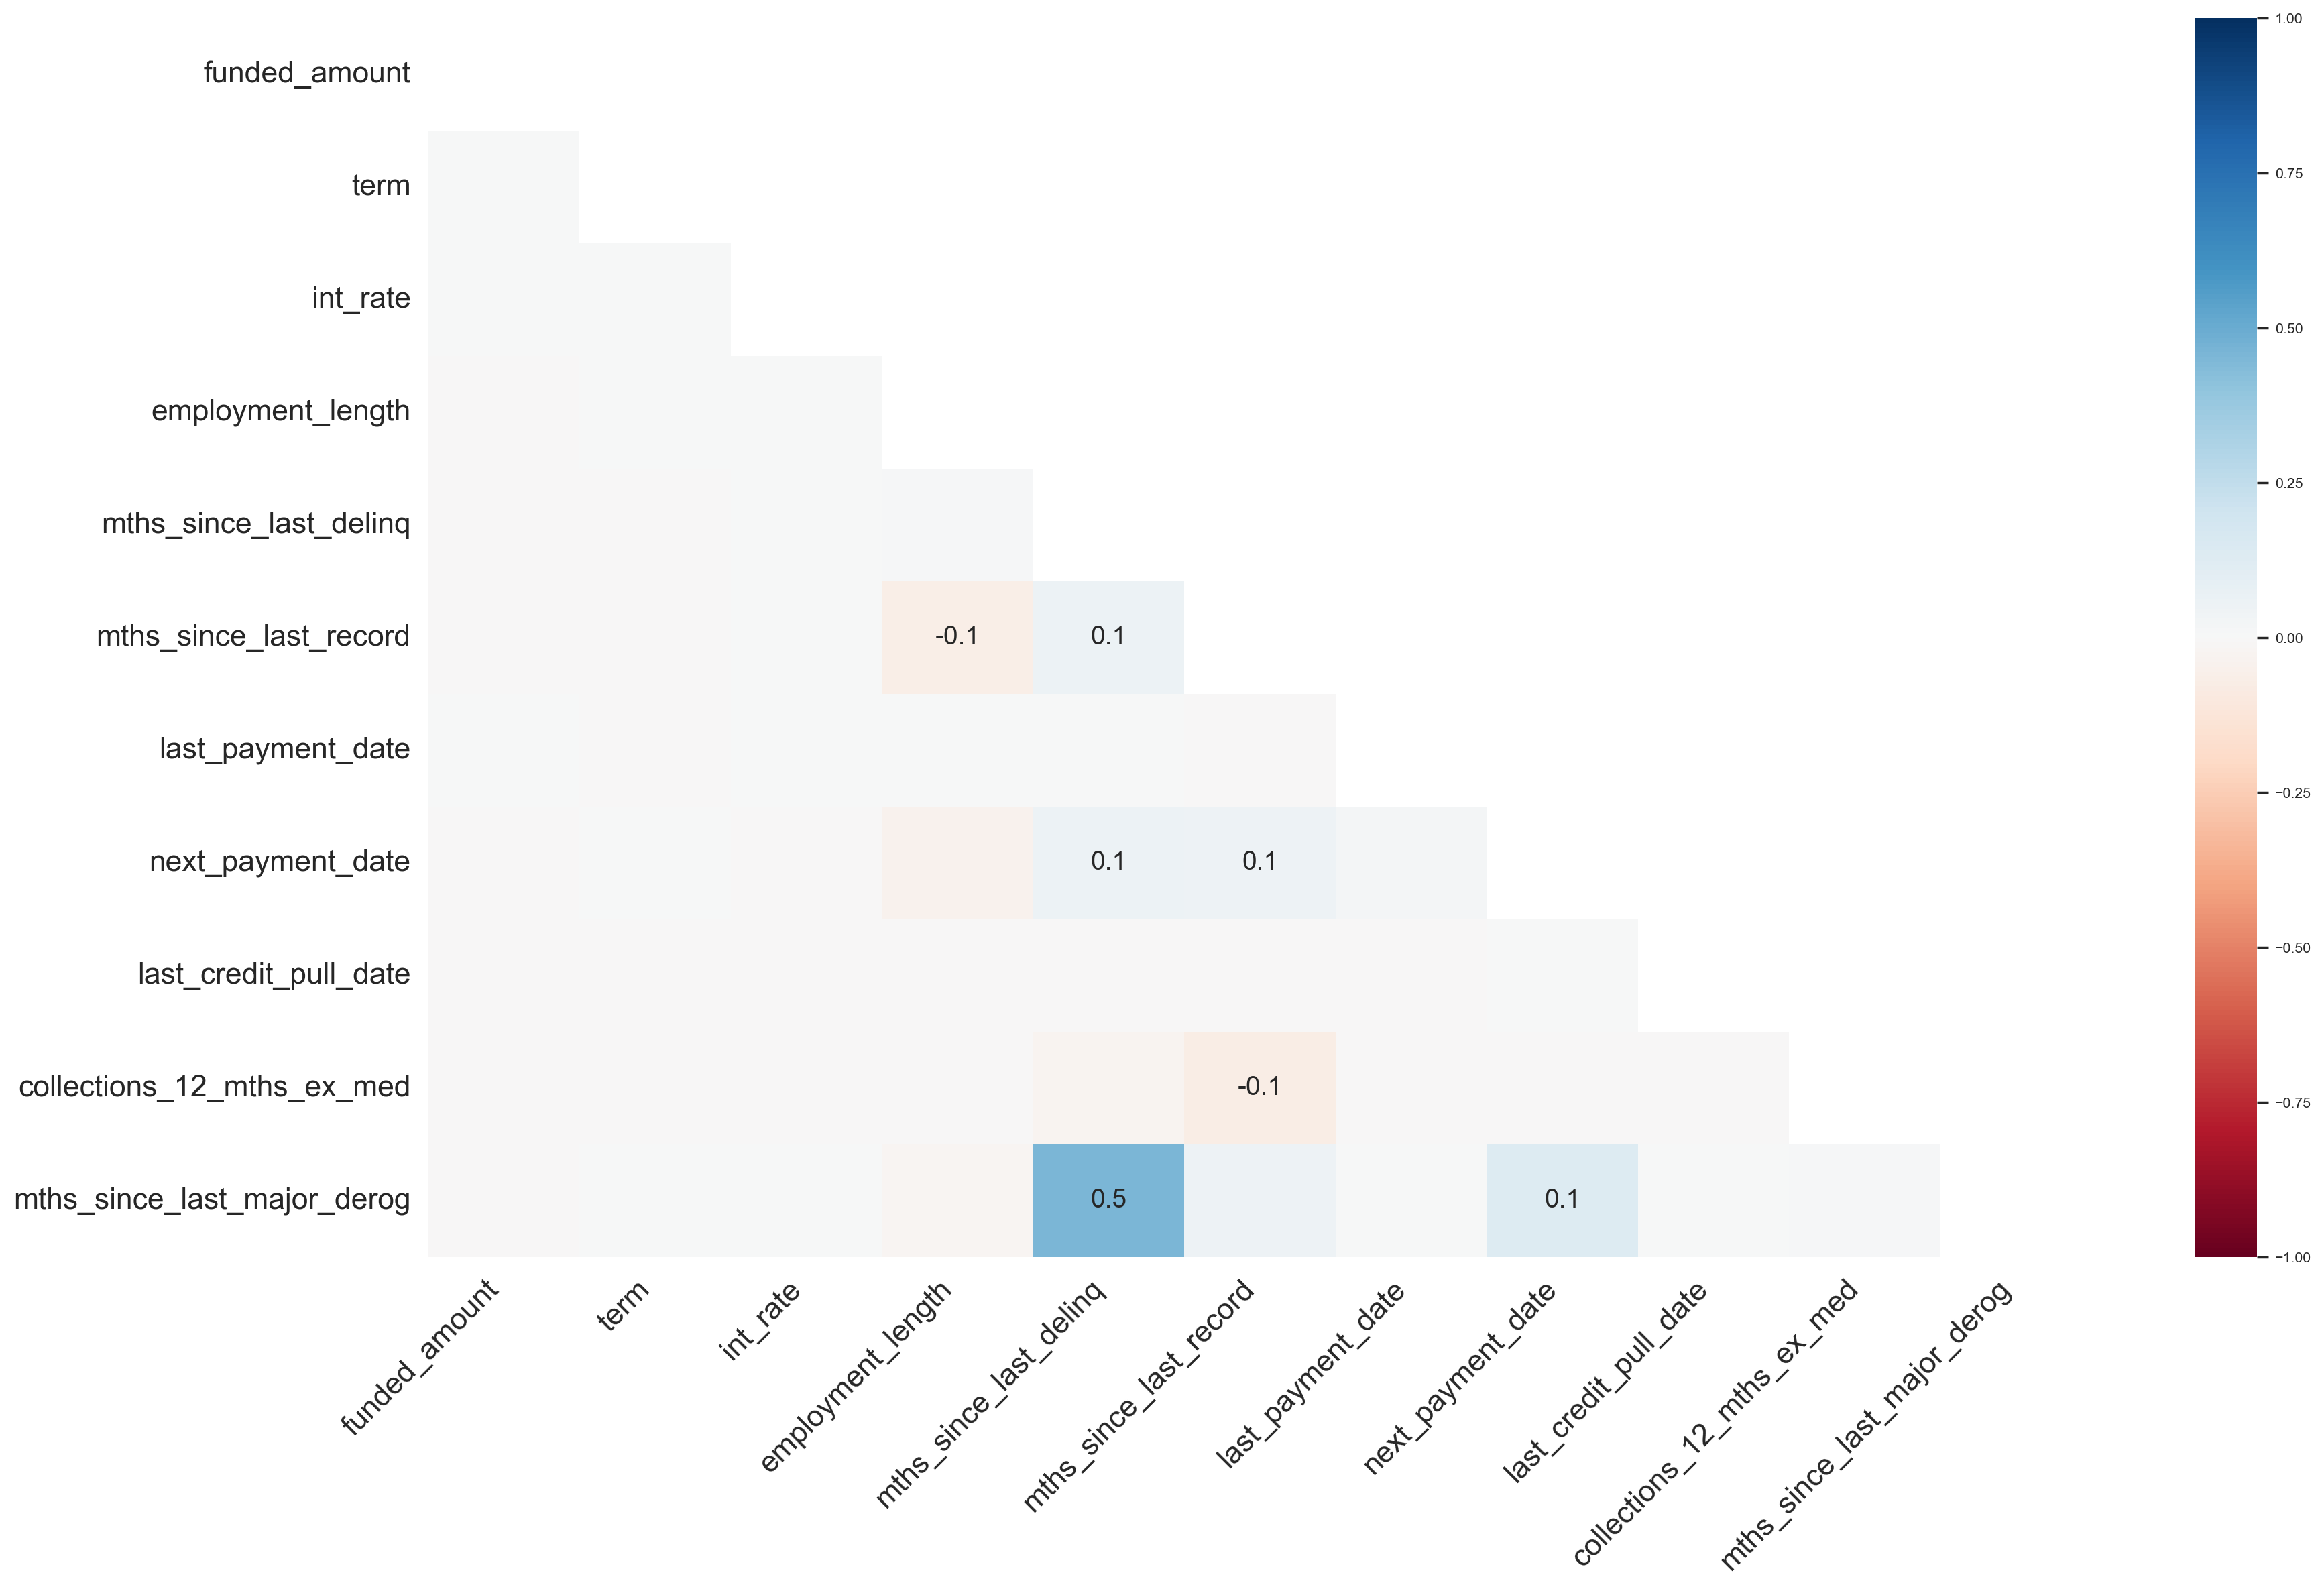

In [55]:
plot.plot_missingno_heatmap(df)

The heatmap suggest the majority of missing data is likely MCAR except for '*mths_since_last_major_derog*' and '*mths_since_last_delinq*'. However these two columns have a very high percentage of nulls so I will drop them from the dataframe.

In [56]:
# Drop columns
column_list = ['mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog', 'next_payment_date']
df_transform = DataFrameTransform()
df = df_transform.drop_columns(df, column_list)

# check shape
transform.print_shape(df)

The shape of the dataframe is (54231, 39).


The columns '*last_payment_date*', '*last_credit_pull_date*', and '*collections_12_mths_ex_med*' have a very low number of nulls in them so I will remove the rows where they are present as this will have little effect on the analysis.

In [57]:
column_list = ['last_payment_date', 'last_credit_pull_date', 'collections_12_mths_ex_med']

# Drop rows
df = df_transform.drop_nulls(df, columns=column_list)
transform.print_shape(df)

131 rows have been removed from the dataframe.
The shape of the dataframe is (54100, 39).


I will now check the data types of the remaining columns and transform the datatypes as necessary.

In [58]:
transform.check_data_type(df)

id                              int64
member_id                       int64
loan_amount                     int64
funded_amount                 float64
funded_amount_inv             float64
term                           object
int_rate                      float64
instalment                    float64
grade                          object
sub_grade                      object
employment_length              object
home_ownership                 object
annual_inc                    float64
verification_status            object
issue_date                     object
loan_status                    object
payment_plan                   object
purpose                        object
dti                           float64
delinq_2yrs                     int64
earliest_credit_line           object
inq_last_6mths                  int64
open_accounts                   int64
total_accounts                  int64
out_prncp                     float64
out_prncp_inv                 float64
total_paymen

First I will transform the columns where the dates are given as 'month-year' to the datetime datatype. These columns are:

1. issue_date
2. earliest_credit_line
3. last_payment_date
4. next_payment_date
5. last_credit_pull_date

Since we are only given the month and not day I will leave the dates set for the first of each month

In [59]:
data_transform = DataTransform()
column_list = ['issue_date', 'earliest_credit_line', 'last_payment_date', 'last_credit_pull_date']

for column in column_list:
    df[column] = data_transform.to_datetime(df, column, '%b-%Y')

#check result
df[column_list].sample(5)

issue_date earliest_credit_line last_payment_date last_credit_pull_date
45817 2016-09-01           1988-10-01        2019-09-01            2022-01-01
23431 2019-09-01           1999-11-01        2021-12-01            2022-01-01
39432 2017-07-01           1996-09-01        2019-05-01            2019-10-01
49951 2016-01-01           1993-05-01        2016-06-01            2016-06-01
44143 2016-12-01           2007-07-01        2018-01-01            2018-05-01

I will now check for columns that should be transformed to categorical.

In [60]:
# proposed list of categorical columns
column_list = ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'loan_status',  'payment_plan', 
                                  'purpose', 'application_type']
transform.get_distinct_count(df, column_list)

grade                   7
sub_grade              35
home_ownership          5
verification_status     3
loan_status             9
payment_plan            2
purpose                14
application_type        1
dtype: int64

In [61]:
# transform columns to categorical
df[column_list] = data_transform.to_categorical(df, column_list)

We have a couple of awkard columns, namely 'term' and 'employment_length', maybe categorical but could be used in future calculations. First we will deal with the 'term' column. I will transform it to a string datatype remove the word 'month' and then transform to float. Once I decide how to deal with the nulls I will cast this column to int.

In [62]:
df['term'] = data_transform.to_string(df, 'term')
df['term'] = data_transform.string_replace(df, 'term', r'\D+', '', regex=True)
df['term'] = data_transform.to_float64(df, 'term')

In [63]:
#Check for unique values in 'employment_length'
transform.get_unique_values(df, 'employment_length')

array(['5 years', '9 years', '8 years', '1 year', '10+ years', '< 1 year',
       nan, '7 years', '3 years', '4 years', '6 years', '2 years'],
      dtype=object)

We will do the same for 'employment_length', changing '10+' to '10' and '<1 year' to 0. 

In [64]:
df['employment_length'] = data_transform.to_string(df, 'employment_length')

df['employment_length'] =  data_transform.string_replace(df, 'employment_length', '+ years', '')
df['employment_length'] =  data_transform.string_replace(df, 'employment_length', '< 1 year', str(0))
df['employment_length'] =  data_transform.string_replace(df, 'employment_length', ' years', '')
df['employment_length'] =  data_transform.string_replace(df, 'employment_length', ' year', '')
df['employment_length'] = data_transform.to_float64(df, 'employment_length')

# Check results
transform.get_unique_values(df, 'employment_length')

array([ 5.,  9.,  8.,  1., 10.,  0., nan,  7.,  3.,  4.,  6.,  2.])

In [65]:
# Check number of unique values of 'term'
transform.get_distinct_count(df, 'term')

2

It seems that there are only 36 and 60 month terms for the loans. There is approximately 9% of the data missing in this column. In this case I think I will impute the missing values with the mode.

In [66]:
df['term'] = df_transform.impute_mode(df, 'term')
df['term'] = data_transform.to_int64(df, 'term')

Let's check which columns still have nulls.

In [67]:
# Check remaining columns with nulls
missing_data = transform.null_counts(df)
display(missing_data)

There are 54100 records in the database.
The columns that contain nulls are listed below along with their null counts/percentages.


Null_Count  Percentage_of_Nulls
funded_amount            2998                 5.54
int_rate                 5159                 9.54
employment_length        2114                 3.91

I will now investigate the remaining columns to decide how to best deal with the nulls. Let's check the stats for each column.

In [68]:
transform.get_stats(df[['int_rate', 'employment_length']])

int_rate  employment_length
count  48941.000000       51986.000000
mean      13.507936           5.695572
std        4.393899           3.648951
min        5.420000           0.000000
25%       10.370000           2.000000
50%       13.160000           6.000000
75%       16.200000          10.000000
max       26.060000          10.000000

It seems that in each case the mean and median are quite close to each other. In the two above cases I will impute the median. For the case of 'funded_amount' it appears that in most cases where there are values they match the left-hand side adjacent column 'loan_amount, so I will double check then decide a course of action.

In [69]:
#impute median 'int rate'
df['int_rate'] = df_transform.impute_median(df, 'int_rate')

In [70]:
#impute median 'employment_length'
df['employment_length'] = df_transform.impute_median(df, 'employment_length')
df['employment_length'] = data_transform.to_int64(df, 'employment_length')


In [71]:
transform.get_median(df,'employment_length')

6.0

In [72]:
# Check assumption that 'funded_amount' == 'loan_amount'. (number of null)
number_of_nulls = transform.null_count(df['funded_amount'], info=False)
print(df[df['loan_amount'] != df['funded_amount']].count().iloc[0] - number_of_nulls)

940


It appears that in a relatively few cases 'funded_amount' does not equal 'loan_amount', so I will just fill the nulls with the values in the adjacent column.

In [73]:
df['funded_amount'] = df_transform.fill_nulls(df, 'funded_amount', df['loan_amount'])

We should now have removed all the nulls.

There are 54100 records in the database.
The columns that contain nulls are listed below along with their null counts/percentages.


Empty DataFrame
Columns: [Null_Count, Percentage_of_Nulls]
Index: []

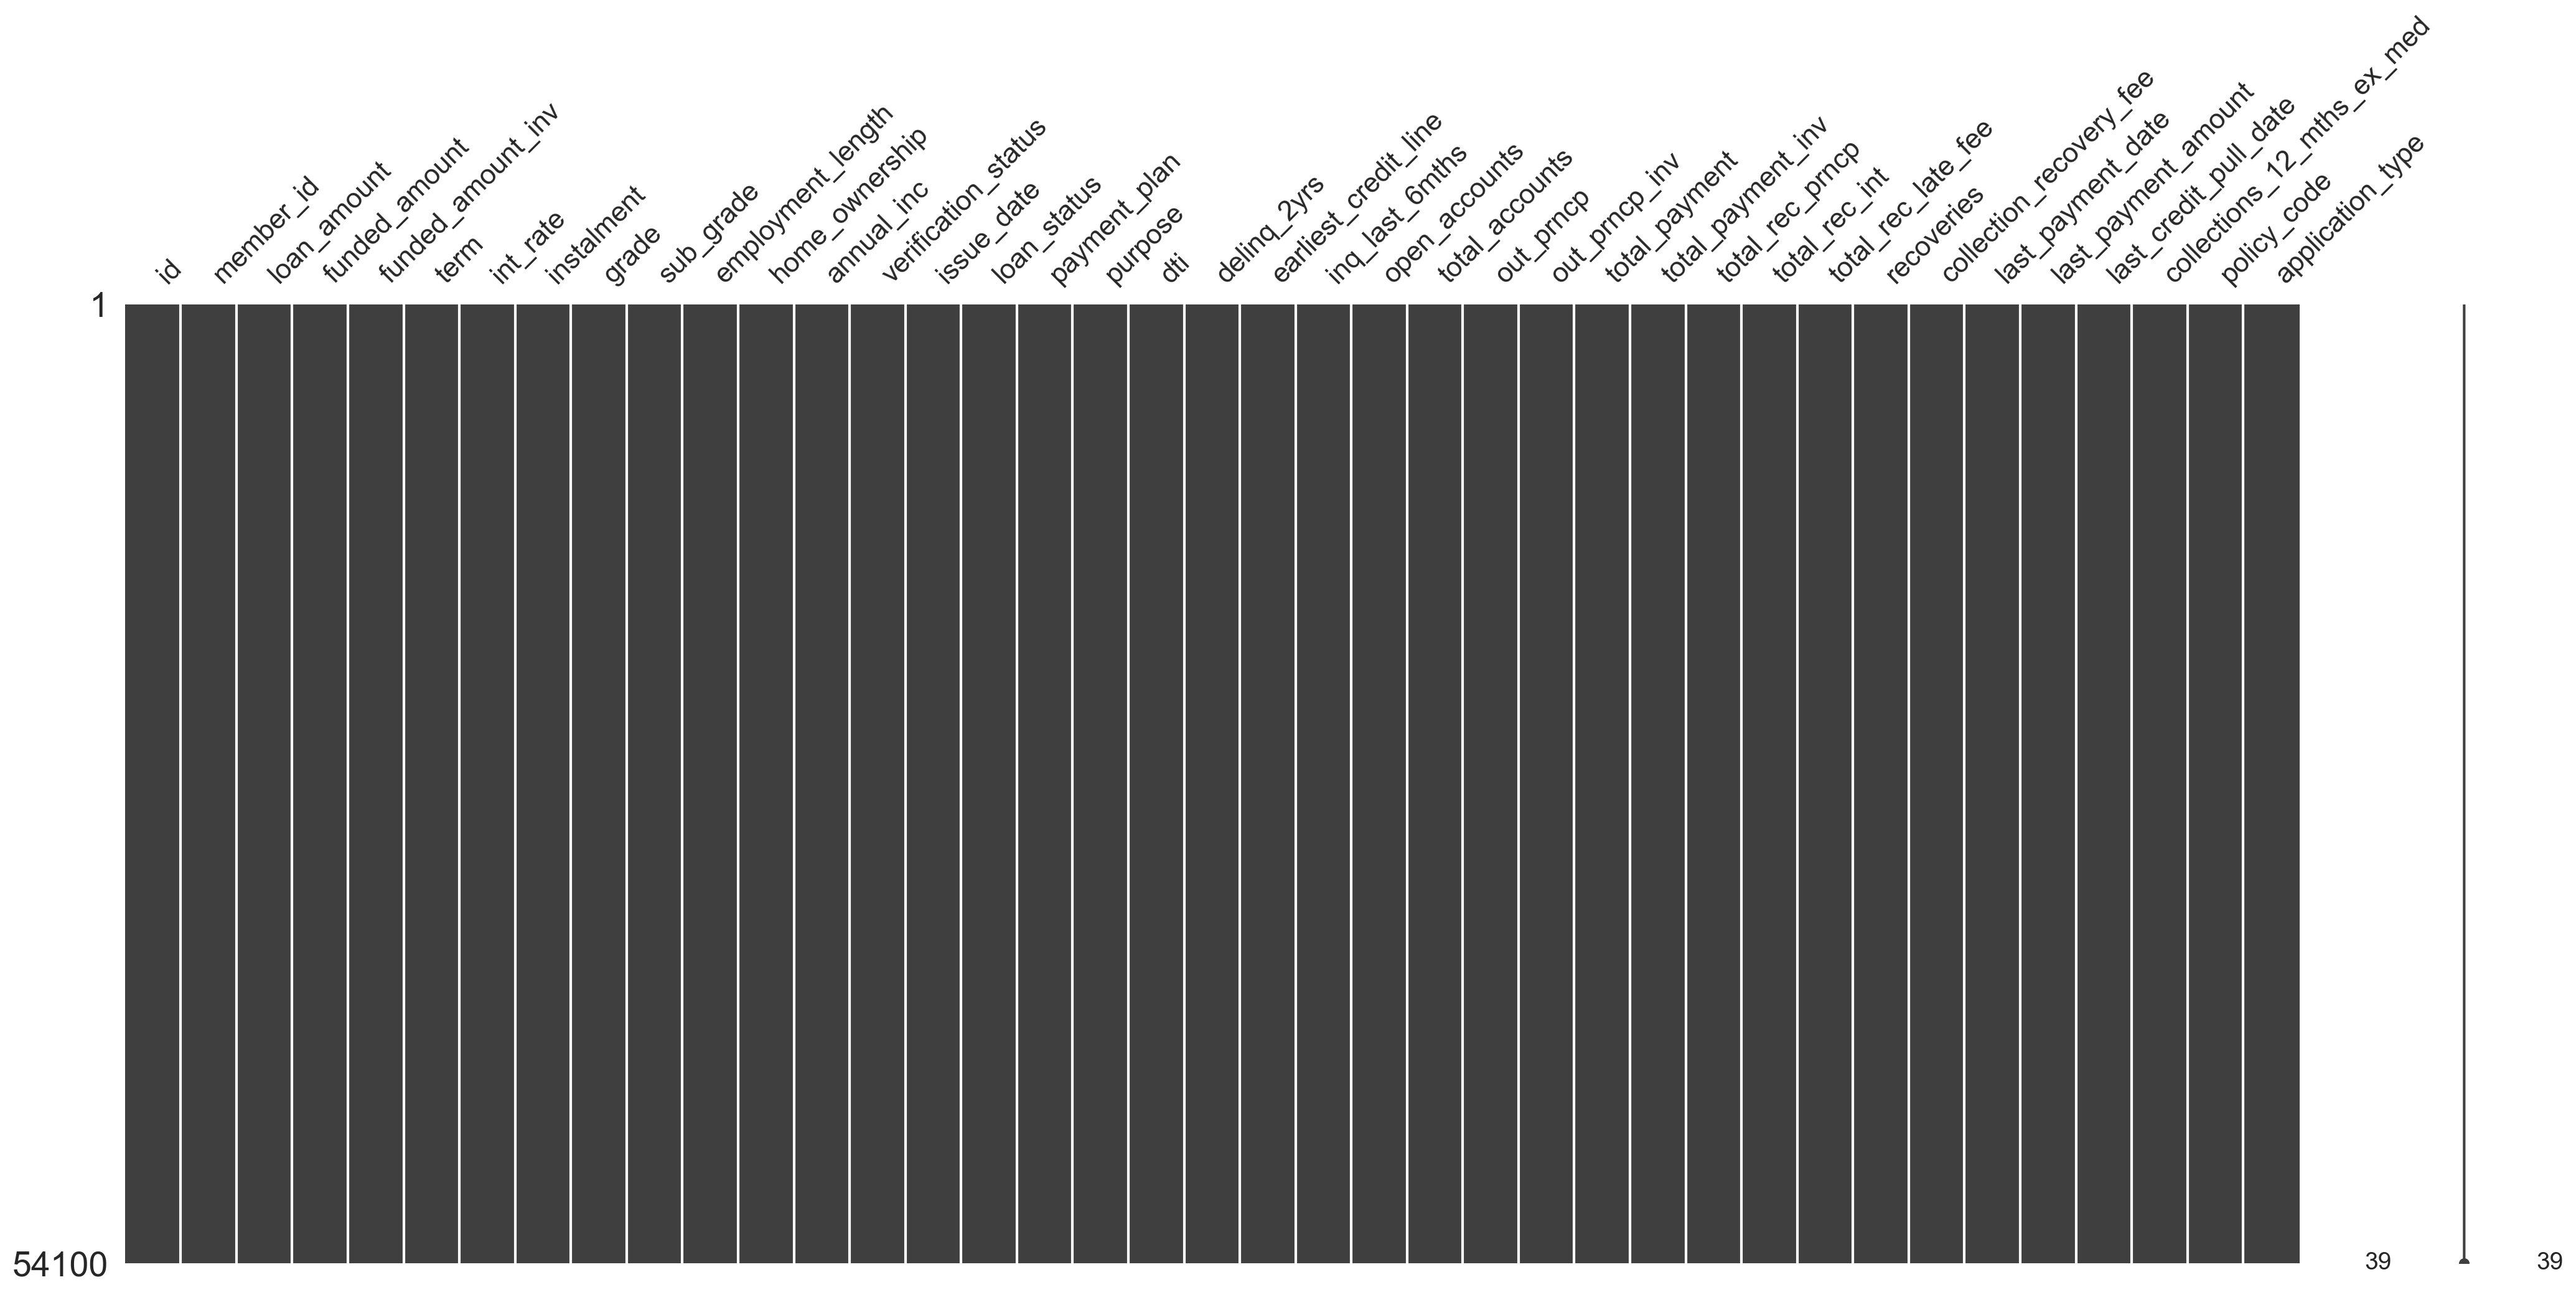

In [74]:
display(transform.null_counts(df))
plot.plot_missingno(df)


It appears that alll nulls have been removed. Before we move on let's double check the data types of the columns.

In [75]:
transform.check_data_type(df)

id                                     int64
member_id                              int64
loan_amount                            int64
funded_amount                        float64
funded_amount_inv                    float64
term                                   int64
int_rate                             float64
instalment                           float64
grade                               category
sub_grade                           category
employment_length                      int64
home_ownership                      category
annual_inc                           float64
verification_status                 category
issue_date                    datetime64[ns]
loan_status                         category
payment_plan                        category
purpose                             category
dti                                  float64
delinq_2yrs                            int64
earliest_credit_line          datetime64[ns]
inq_last_6mths                         int64
open_accou

In [76]:
# Save a copy of the cleaned dataframe in csv format
#df.to_csv('cleaned_loan_data.csv', index_label=False)

#### Task 4

We will now check for skewness in the data. First will we select all relevant numeric data.



In [77]:
#Get numeric columns
excluded_columns = ['id', 'member_id', 'policy_code'] #
numeric_data  = transform.get_numeric_columns(df, exclude=excluded_columns)
#Check skew
df[numeric_data].skew()

loan_amount                    0.804312
funded_amount                  0.819681
funded_amount_inv              0.814251
term                           1.146332
int_rate                       0.456055
instalment                     0.996150
employment_length             -0.129231
annual_inc                     8.735737
dti                            0.189020
delinq_2yrs                    5.318818
inq_last_6mths                 3.243836
open_accounts                  1.059493
total_accounts                 0.780083
out_prncp                      2.352526
out_prncp_inv                  2.352946
total_payment                  1.269266
total_payment_inv              1.258474
total_rec_prncp                1.262007
total_rec_int                  2.203625
total_rec_late_fee            13.258472
recoveries                    14.382675
collection_recovery_fee       27.794716
last_payment_amount            2.496079
collections_12_mths_ex_med    20.298064
dtype: float64

We will plot these distributions to examine the skew.

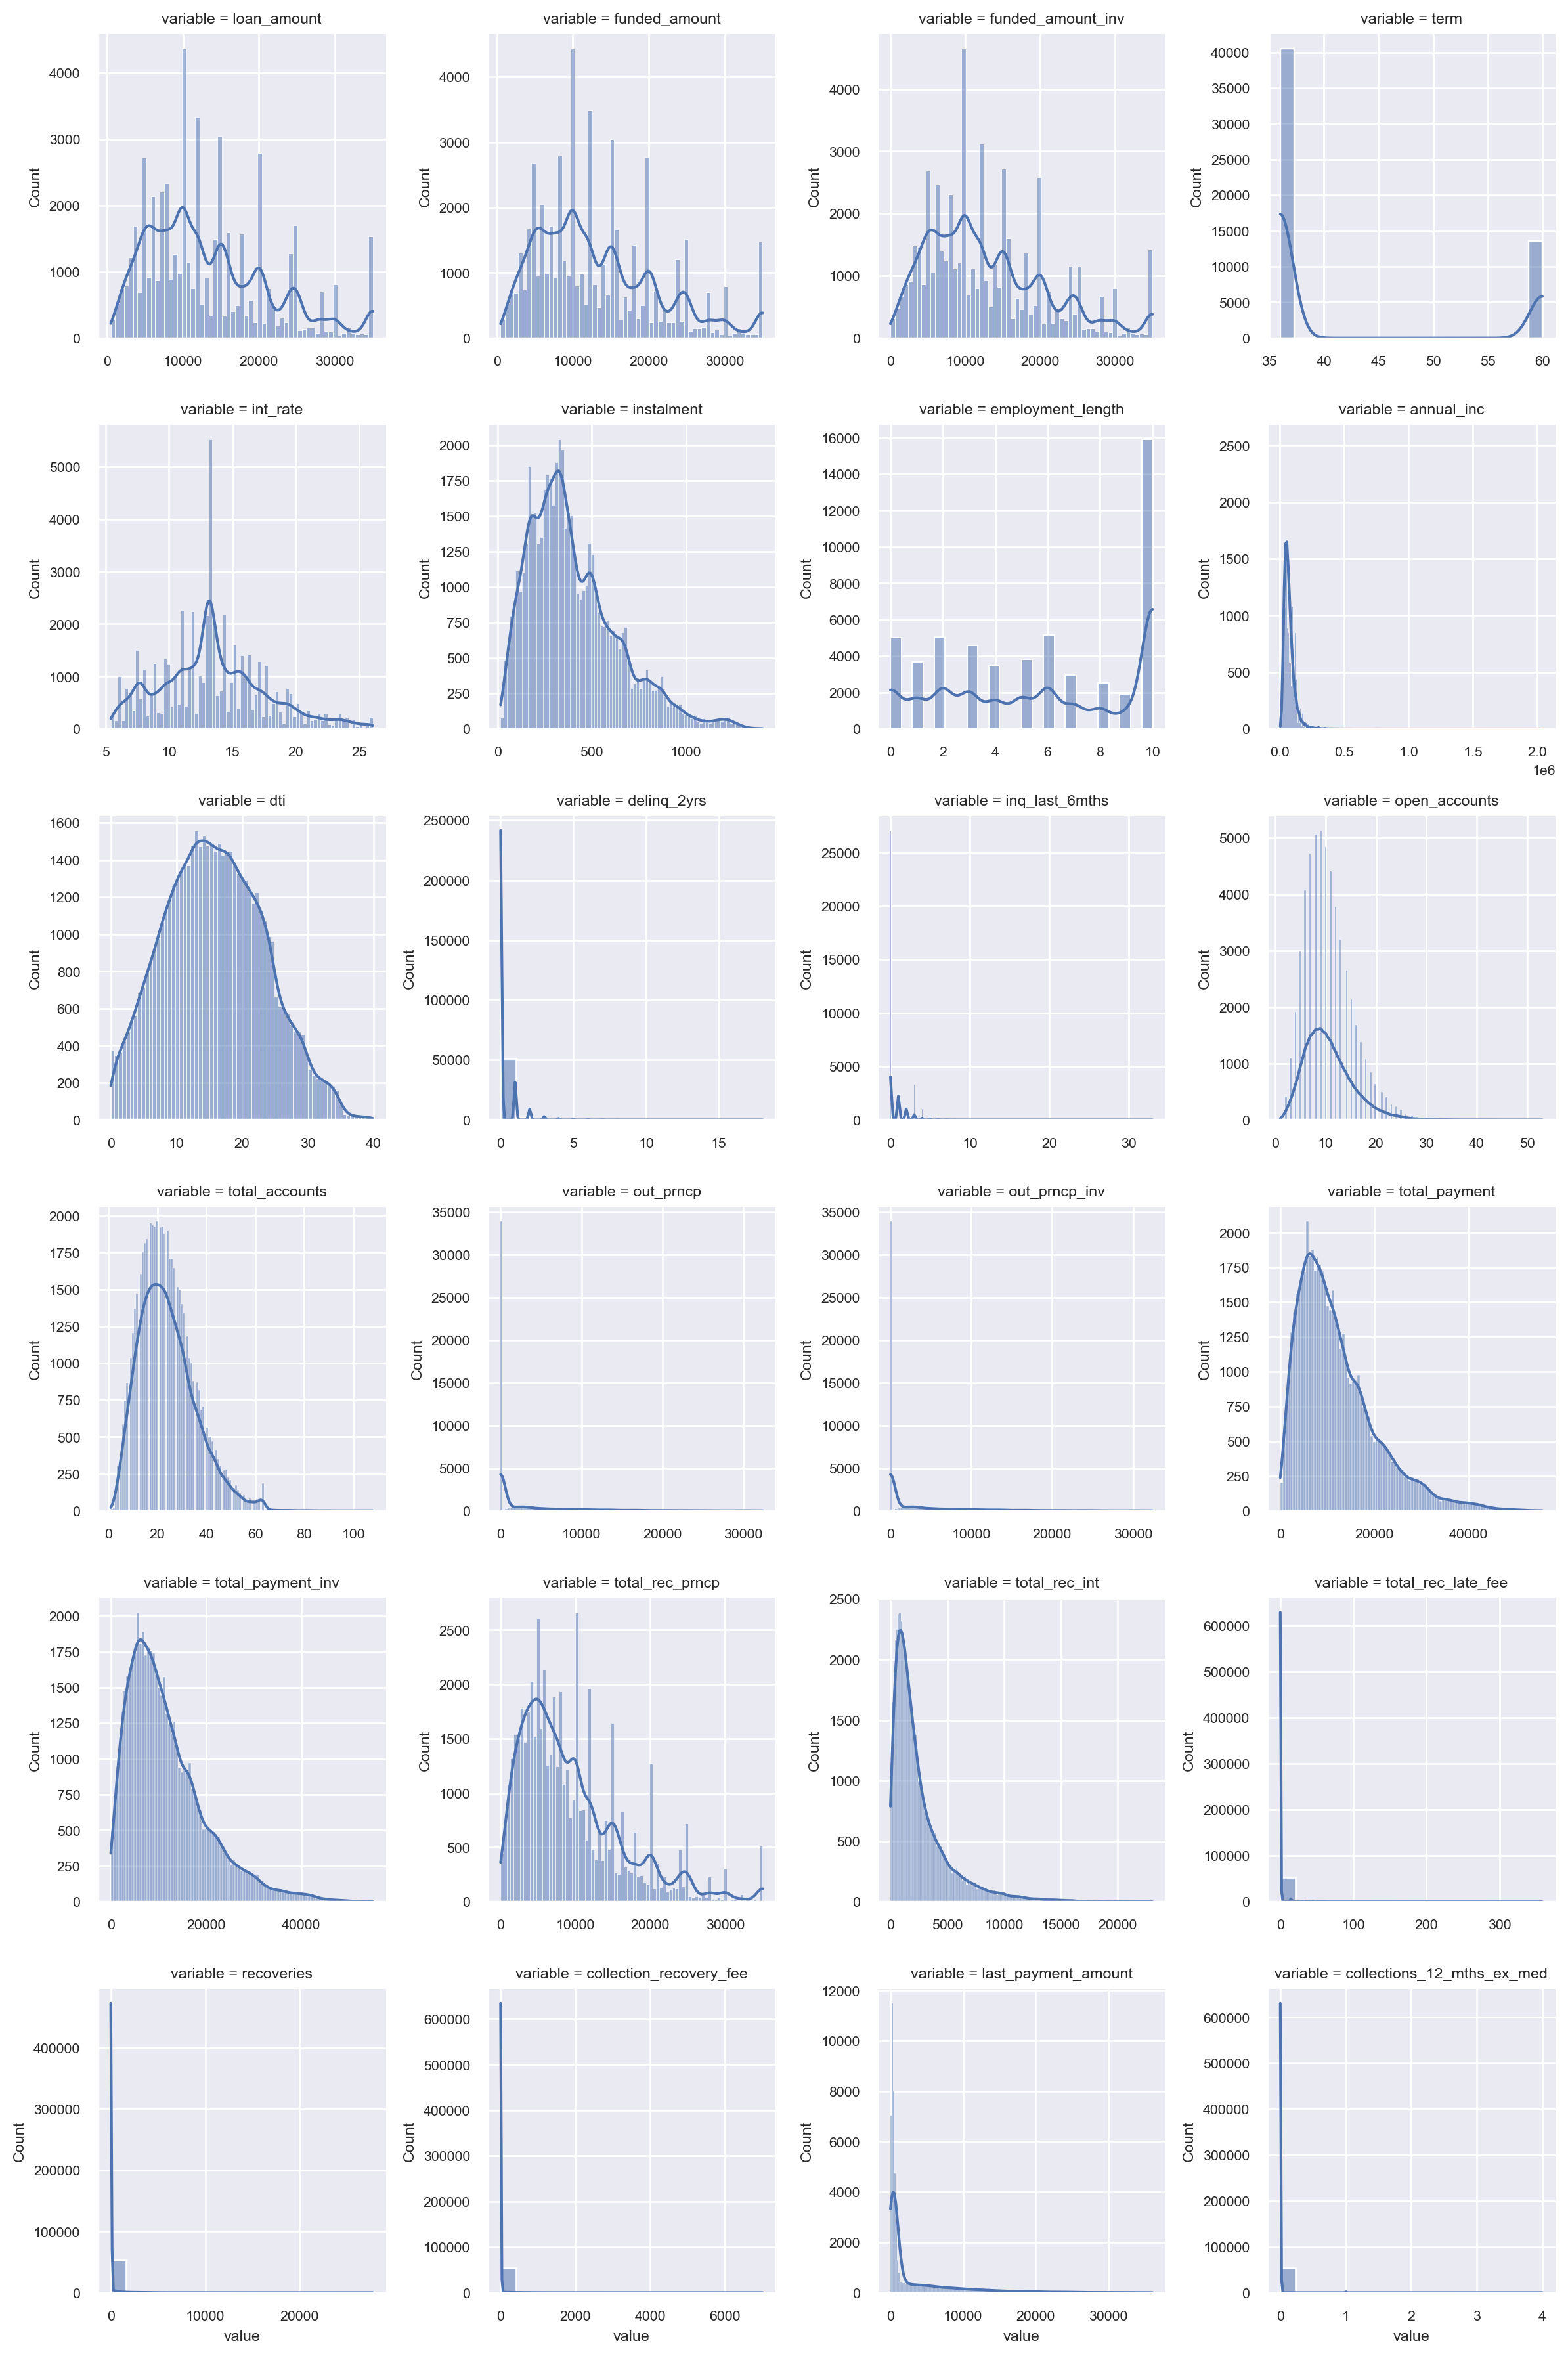

In [78]:
plot.histogram_grid(df, data = numeric_data, columns=4)

Notice that the first three plots are virtually identical, which is not a surprise as they have the same values for the majority of records. Lets plot a qqplot of the '*loan_amount*' column.

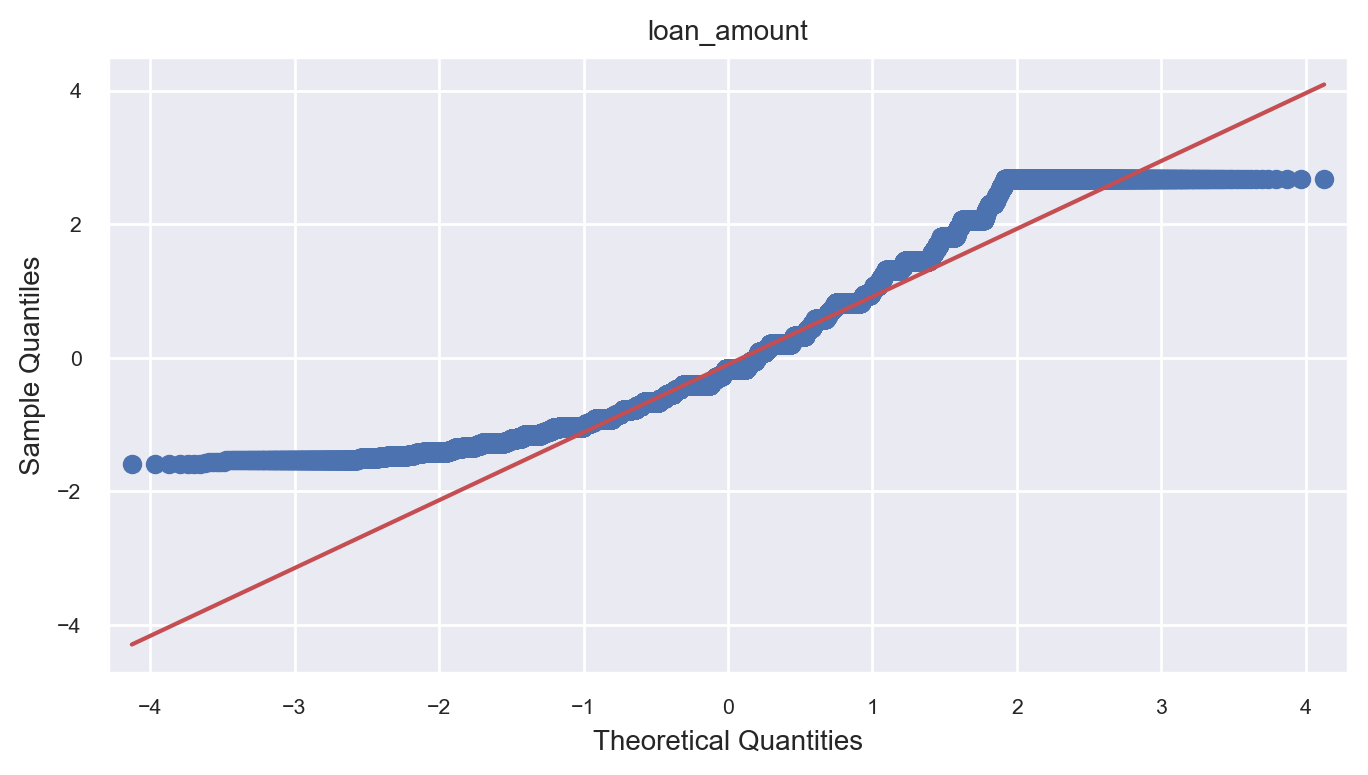

In [79]:
plot.qq_plot(df['loan_amount'], plot_title='loan_amount', fig_size=(8,4))

Looks like we have a fair bit of right skew. We will try applying the log, Box-Cox and Yeo-Johnson transforms to the data and check the results.

In [80]:
df_transform.transform_compare(df, 'loan_amount')

Original skew: 0.8
Skew after log transform: -0.68
Skew after Box-Cox transform: -0.04
Skew after Yeo-Johnson transform: -0.04


The results show that Box-Cox and Yeo-Johnson do a better job than the log transform, both reducing the skew to around -0.04. We will plot these results to get some visual feedback and compare.

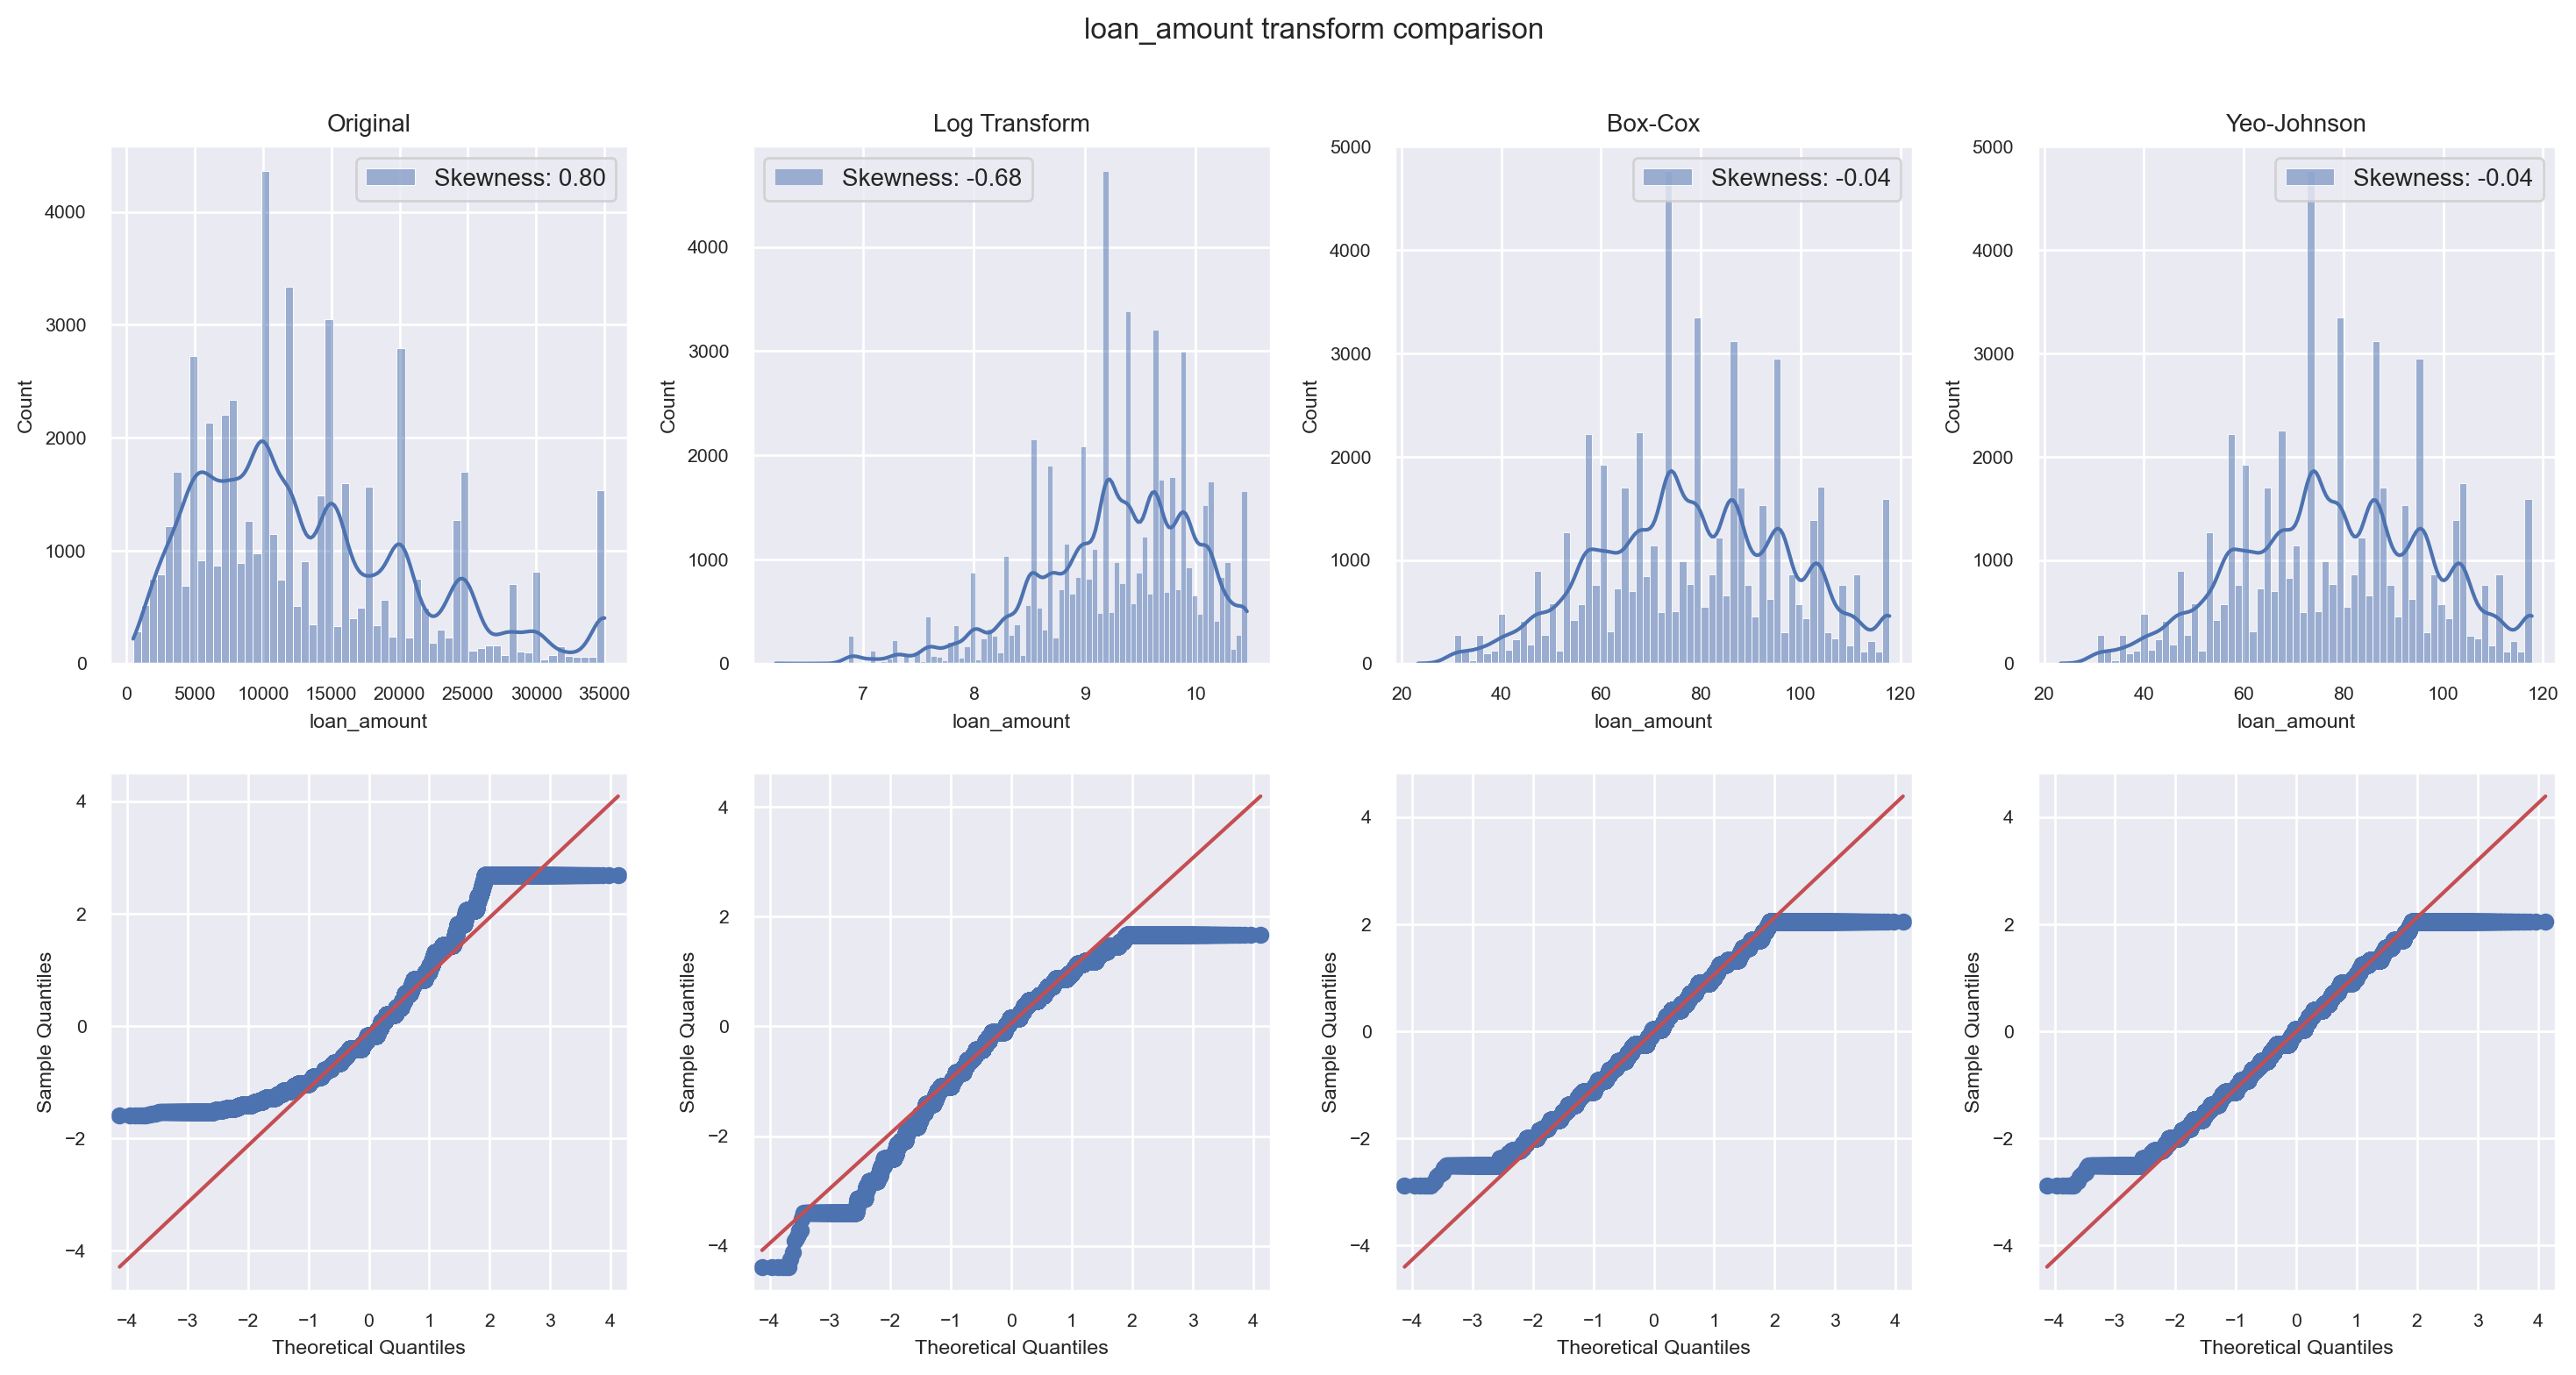

In [81]:
# Plot comparison of different transforms
plot.plot_transform_comparison(df, 'loan_amount', title='loan_amount')

As we see from the plots Box-Cox and Yeo-Johnson do a similar job. The tops and tails are not such a great fit, but it is a marked improvement. The columns 'funded_amount', 'funded_amount_inv' yield similar results. We will apply a Box-Cox transform to 'loan_amount' and 'funded_amount' and Yeo-Johnson to the 'funded_amount_inv' column as not all data is strictly positive in that column.

In [82]:
column_list = ['loan_amount', 'funded_amount']

for column in column_list:
    df[column] = df_transform.box_cox_transform(df, column).values

df['funded_amount_inv'] = df_transform.yeo_johnson_transform(df, 'funded_amount_inv').values
#check results
df[['loan_amount', 'funded_amount', 'funded_amount_inv']].skew()


loan_amount         -0.043080
funded_amount       -0.041253
funded_amount_inv   -0.035006
dtype: float64

The 'term' column only has 2 values so not much to do with this. We will now check the 'int rate column'.

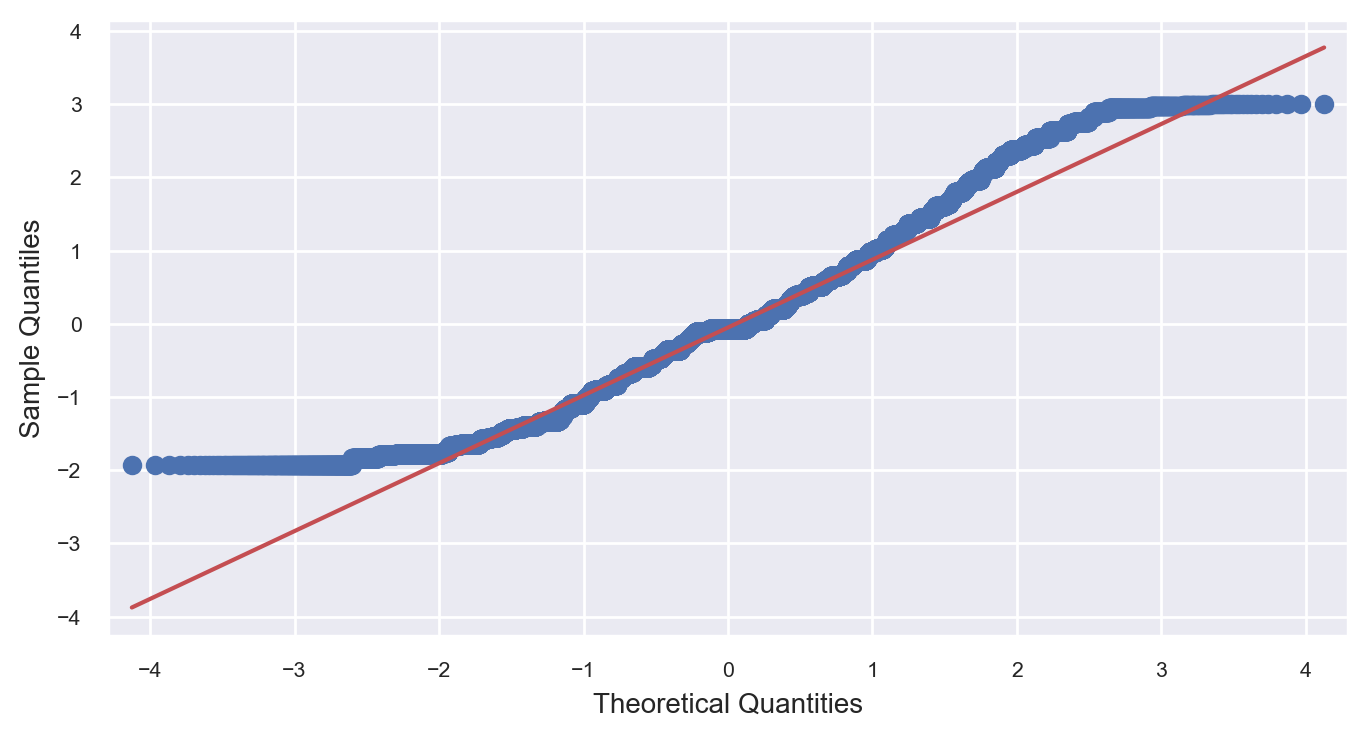

In [83]:
plot.qq_plot(df['int_rate'], fig_size=(8,4))

In [84]:
df_transform.transform_compare(df, 'int_rate')

Original skew: 0.46
Skew after log transform: -0.38
Skew after Box-Cox transform: -0.01
Skew after Yeo-Johnson transform: -0.01


It seems that Box-Cox and Yeo-Johnson give good results.

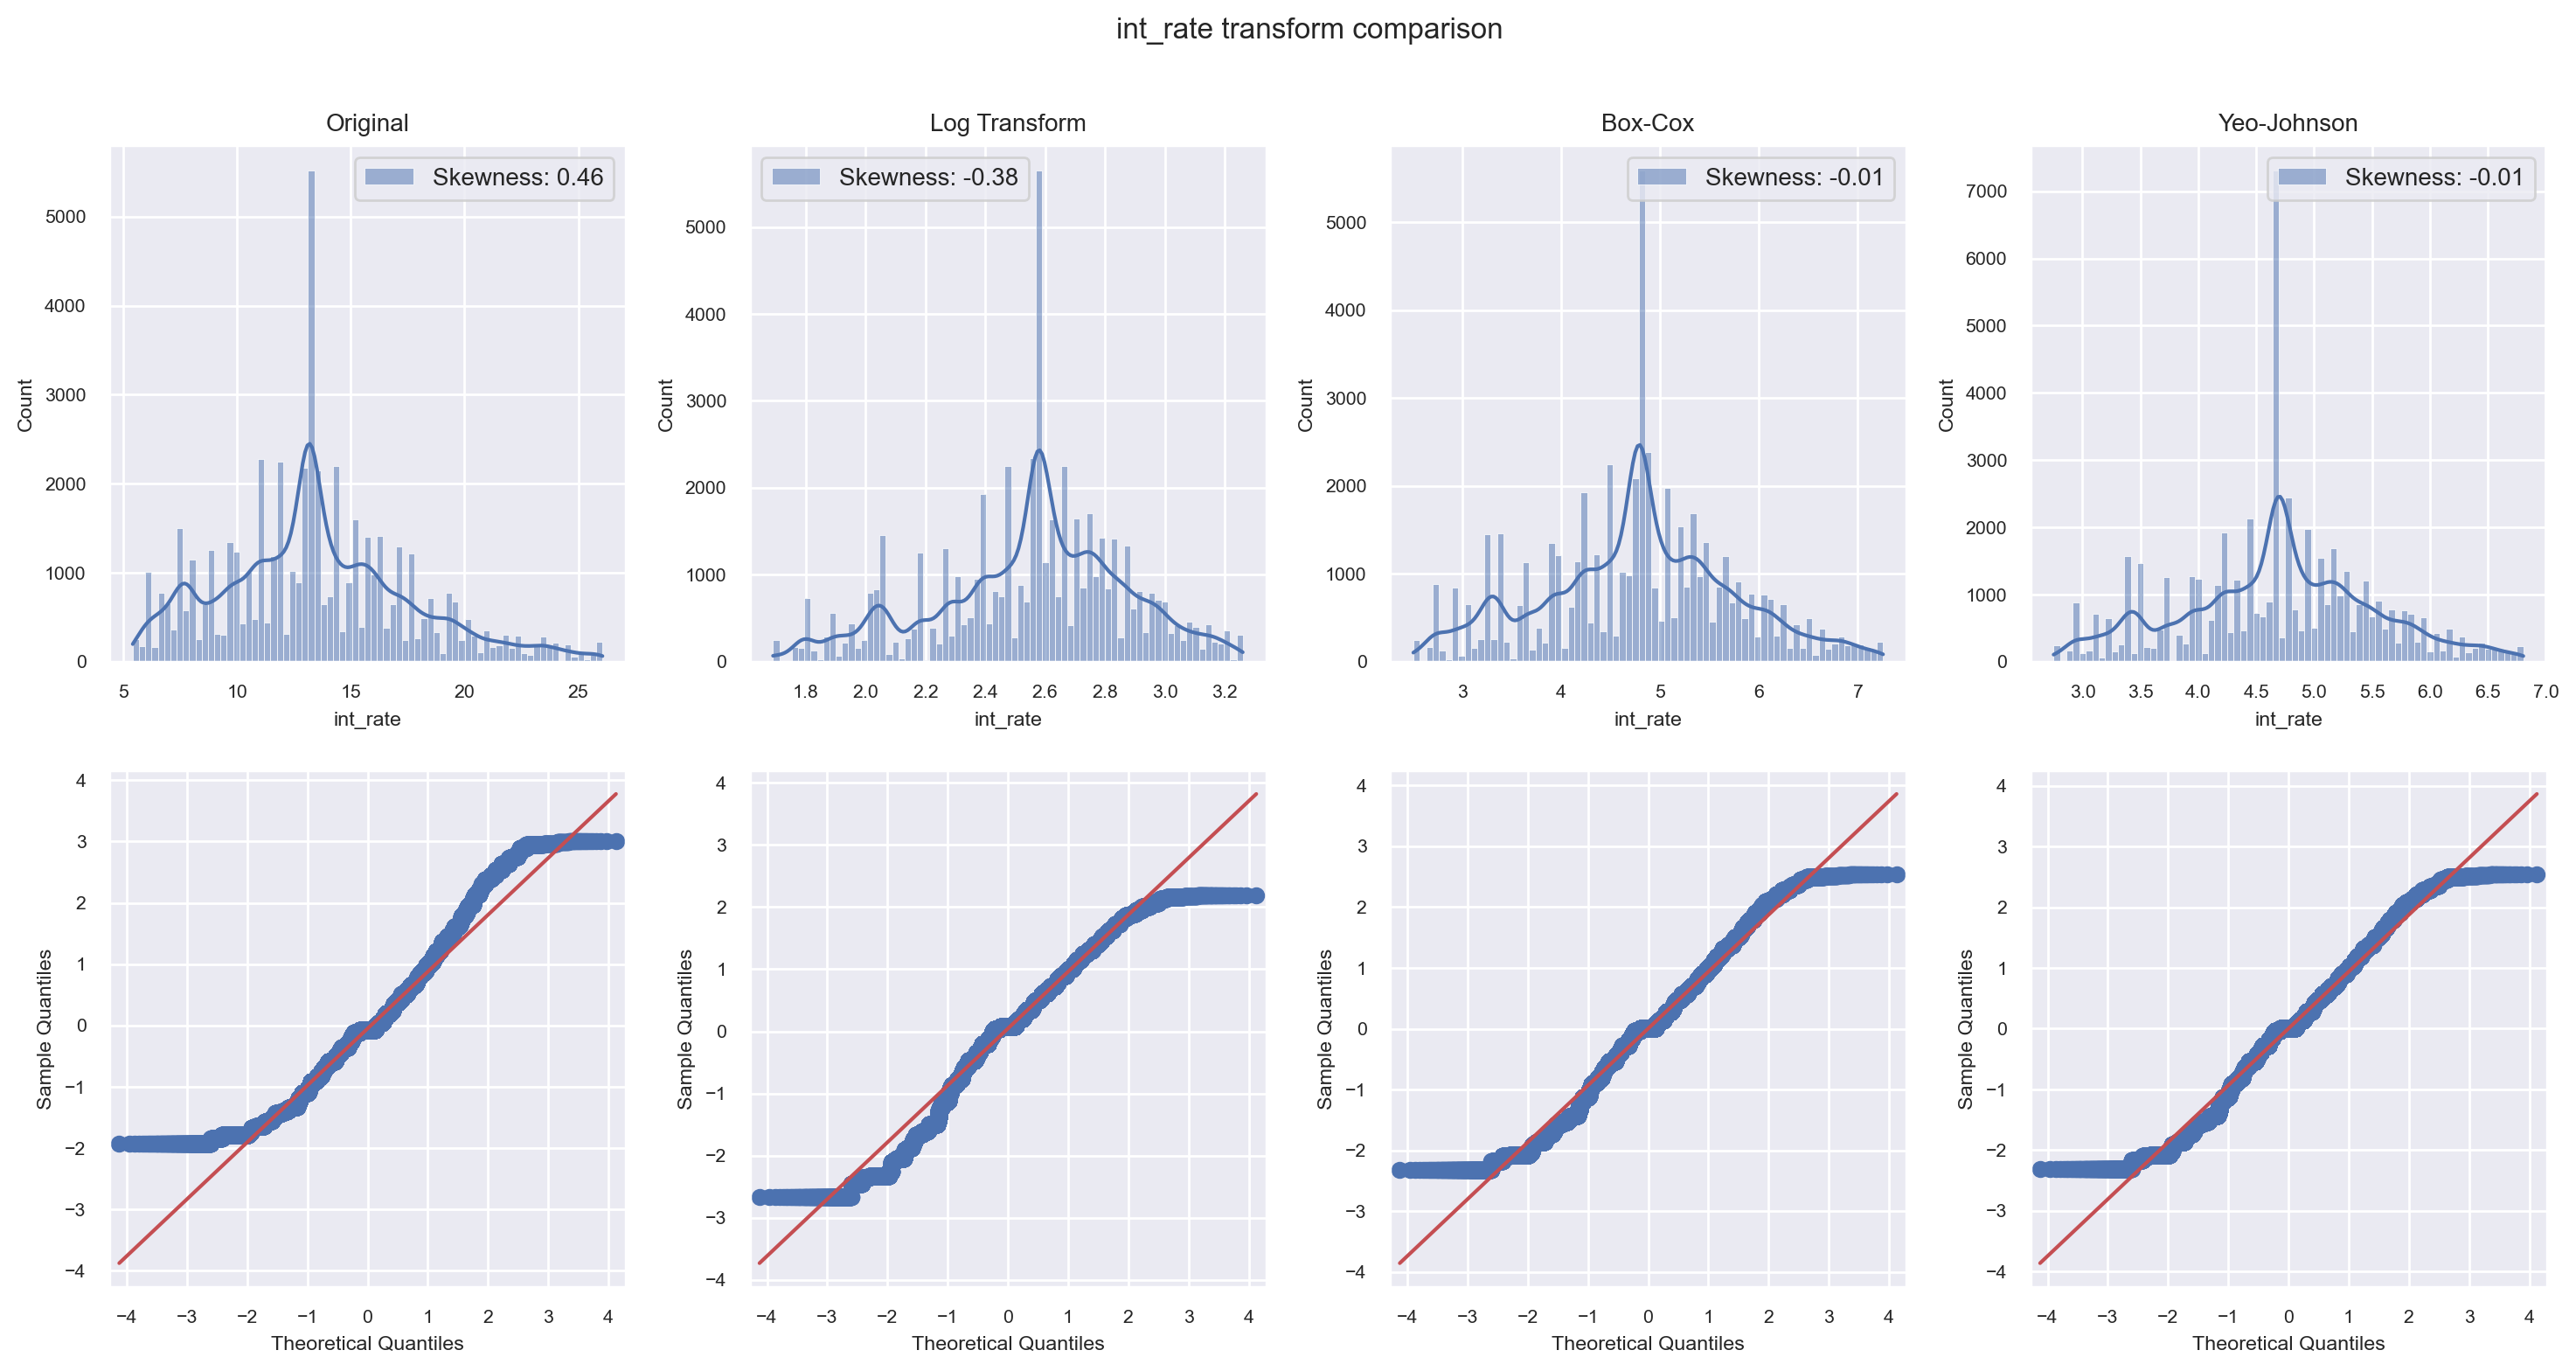

In [85]:
plot.plot_transform_comparison(df, 'int_rate', title='int_rate')

We will apply Box-Cox transform to this column.

In [86]:
df['int_rate'] = df_transform.box_cox_transform(df, 'int_rate').values

Investigating the columns 'annual_inc', 'total_payment' and 'total_rec_int' in the same manner we come to the decision to apply the Box-Cox transform to these.

In [87]:
column_list = ['instalment', 'annual_inc', 'total_payment', 'total_rec_int']

for column in column_list:
    df[column] = df_transform.box_cox_transform(df, column).values

Similarly we will apply Yeo-Johnson to the columns 'open_accounts', 'total_accounts', 'total_payment_inv', 'total_rec_prncp', and 'last_payment_amount'.

In [88]:
column_list = ['open_accounts', 'total_accounts', 'total_payment_inv', 'total_rec_prncp', 'last_payment_amount']

for column in column_list:
    df[column] = df_transform.yeo_johnson_transform(df, column).values

The colunms

1. 'delinq_2yrs', 
2. 'collections_12_mths_ex_med',
3. 'out_prncp', 
4. 'out_prncp_inv', 
5. 'recoveries',
6. 'collection_recovery_fee',
7. 'total_rec_late_fee',
8. 'inq_last_6mths',

did not yield good results. As an example we will plot the 'collection_recovery_fee' column with applied transforms. We will not apply transforms to these columns which have a high level of skew that is with a skew above 2. Also applying transforms to 'dti' did not change it significantly.

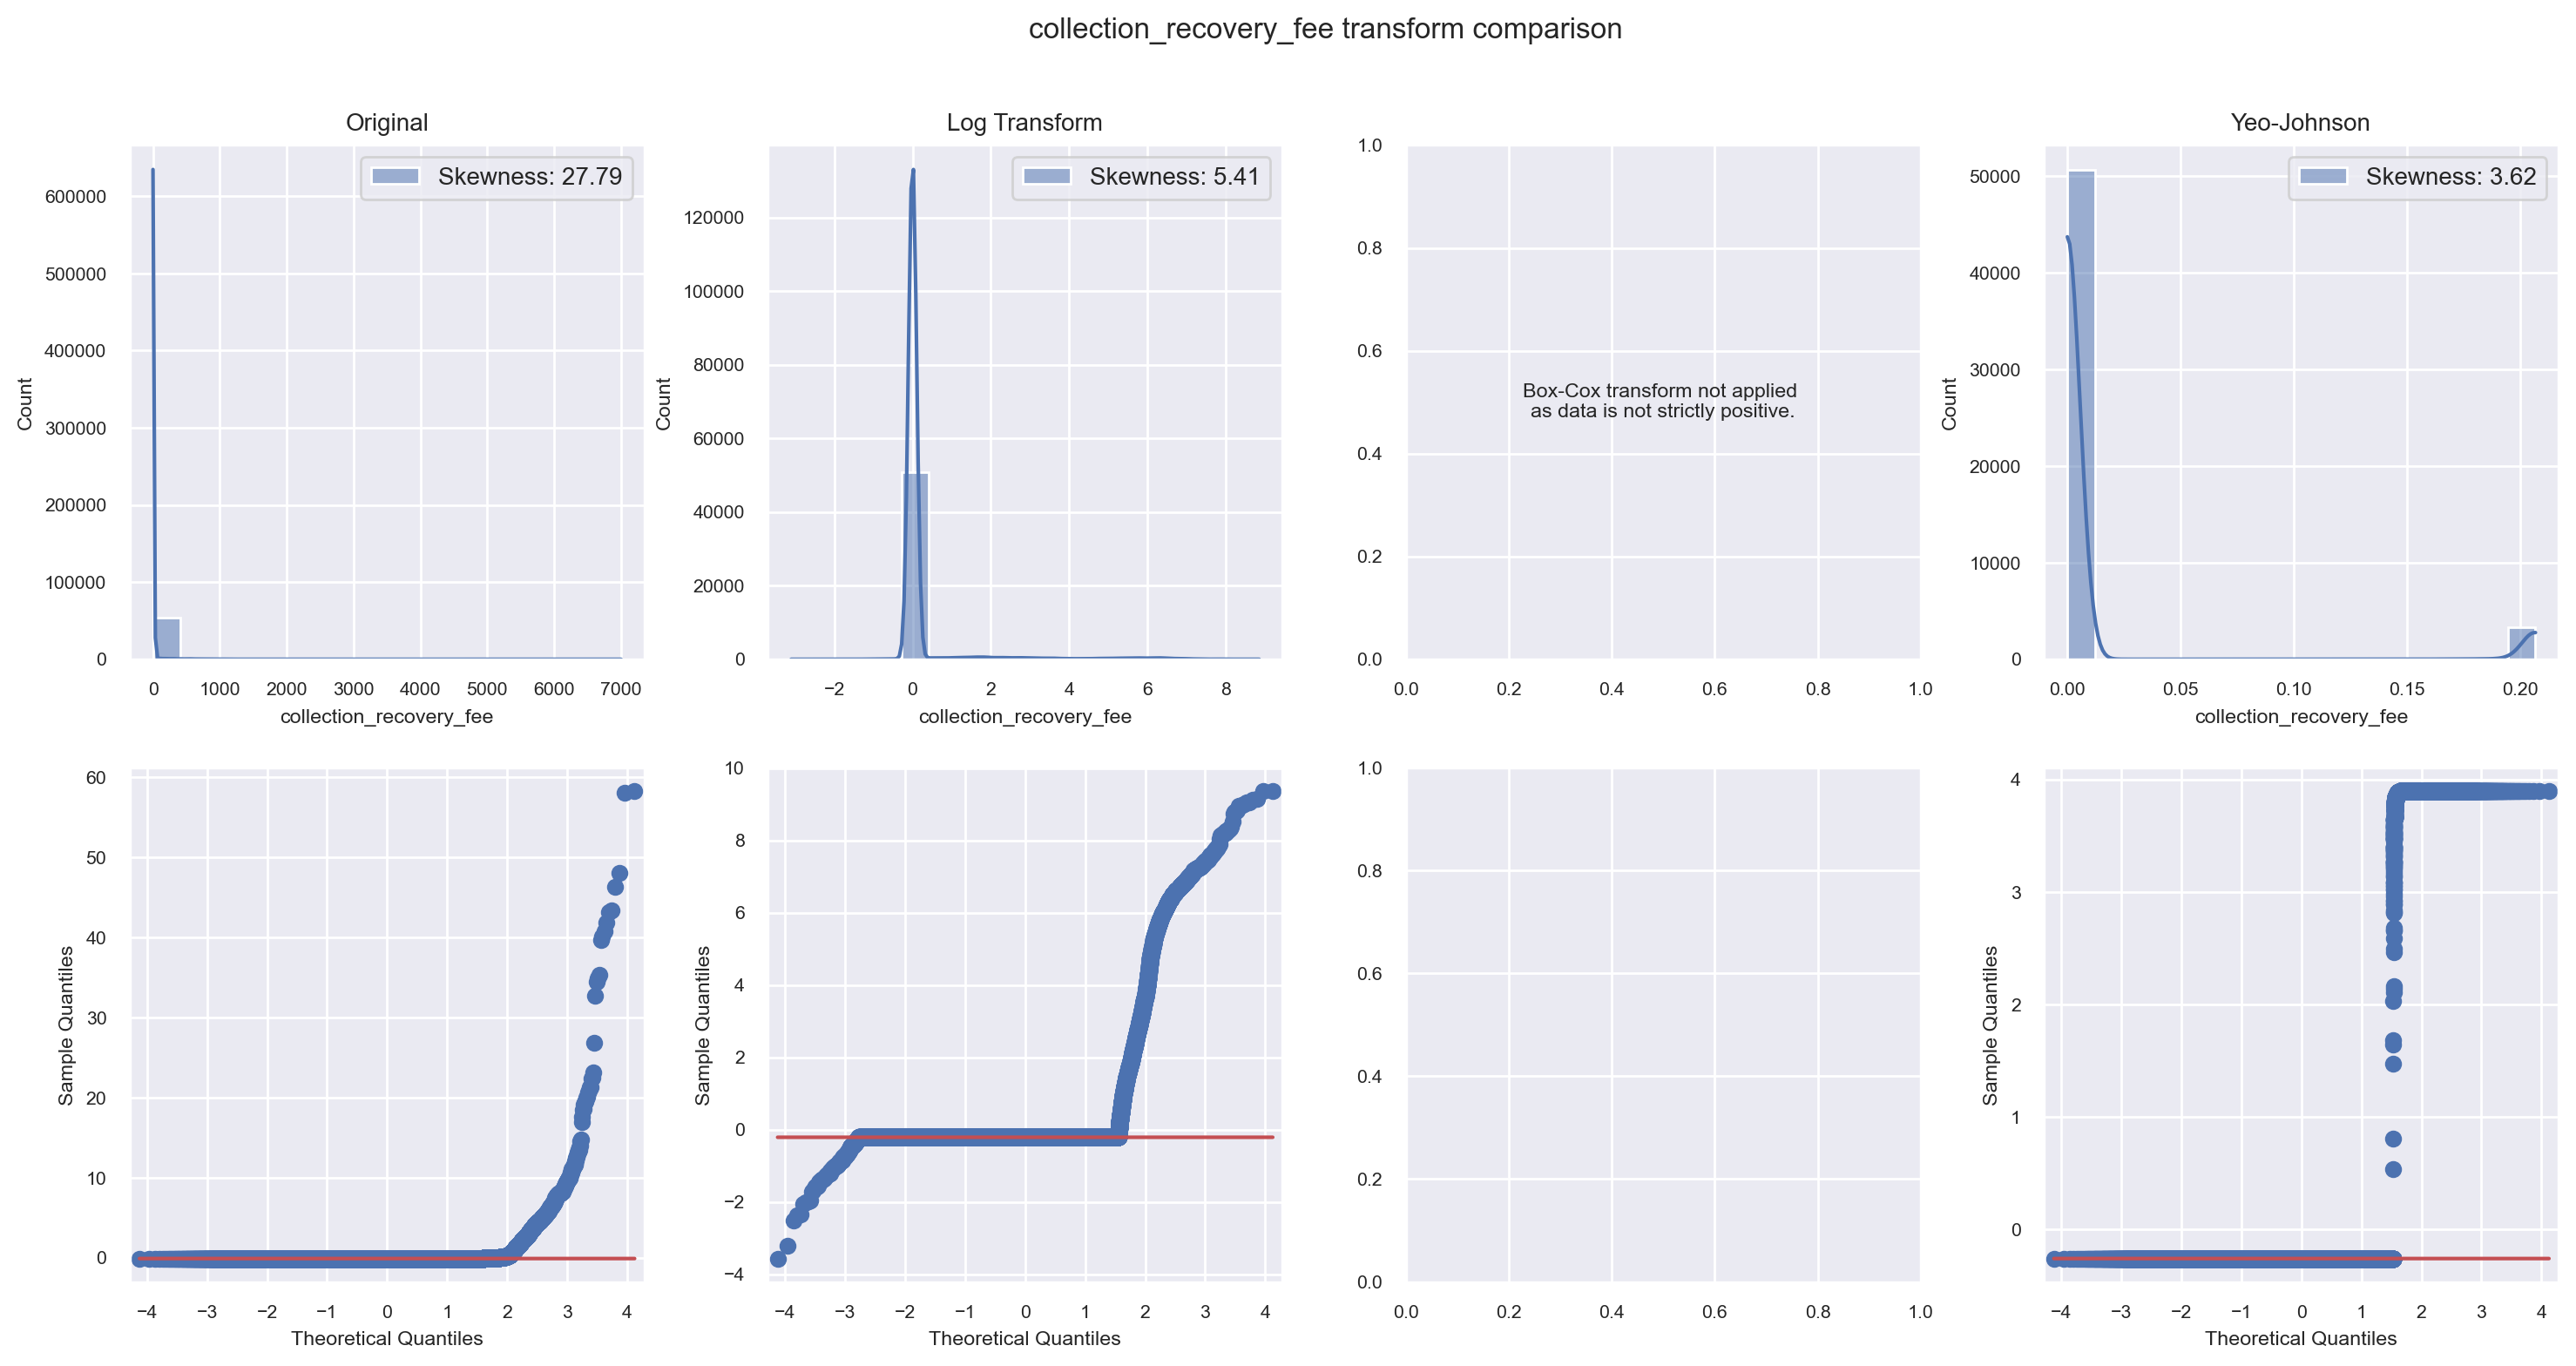

In [89]:
plot.plot_transform_comparison(df, 'collection_recovery_fee', title='collection_recovery_fee')

In [90]:
#Check skew after transformations
df[numeric_data].skew()

loan_amount                   -0.043080
funded_amount                 -0.041253
funded_amount_inv             -0.035006
term                           1.146332
int_rate                      -0.013392
instalment                    -0.020678
employment_length             -0.129231
annual_inc                    -0.012178
dti                            0.189020
delinq_2yrs                    5.318818
inq_last_6mths                 3.243836
open_accounts                  0.001779
total_accounts                -0.012648
out_prncp                      2.352526
out_prncp_inv                  2.352946
total_payment                 -0.013818
total_payment_inv              0.006106
total_rec_prncp               -0.017689
total_rec_int                  0.001729
total_rec_late_fee            13.258472
recoveries                    14.382675
collection_recovery_fee       27.794716
last_payment_amount            0.001581
collections_12_mths_ex_med    20.298064
dtype: float64

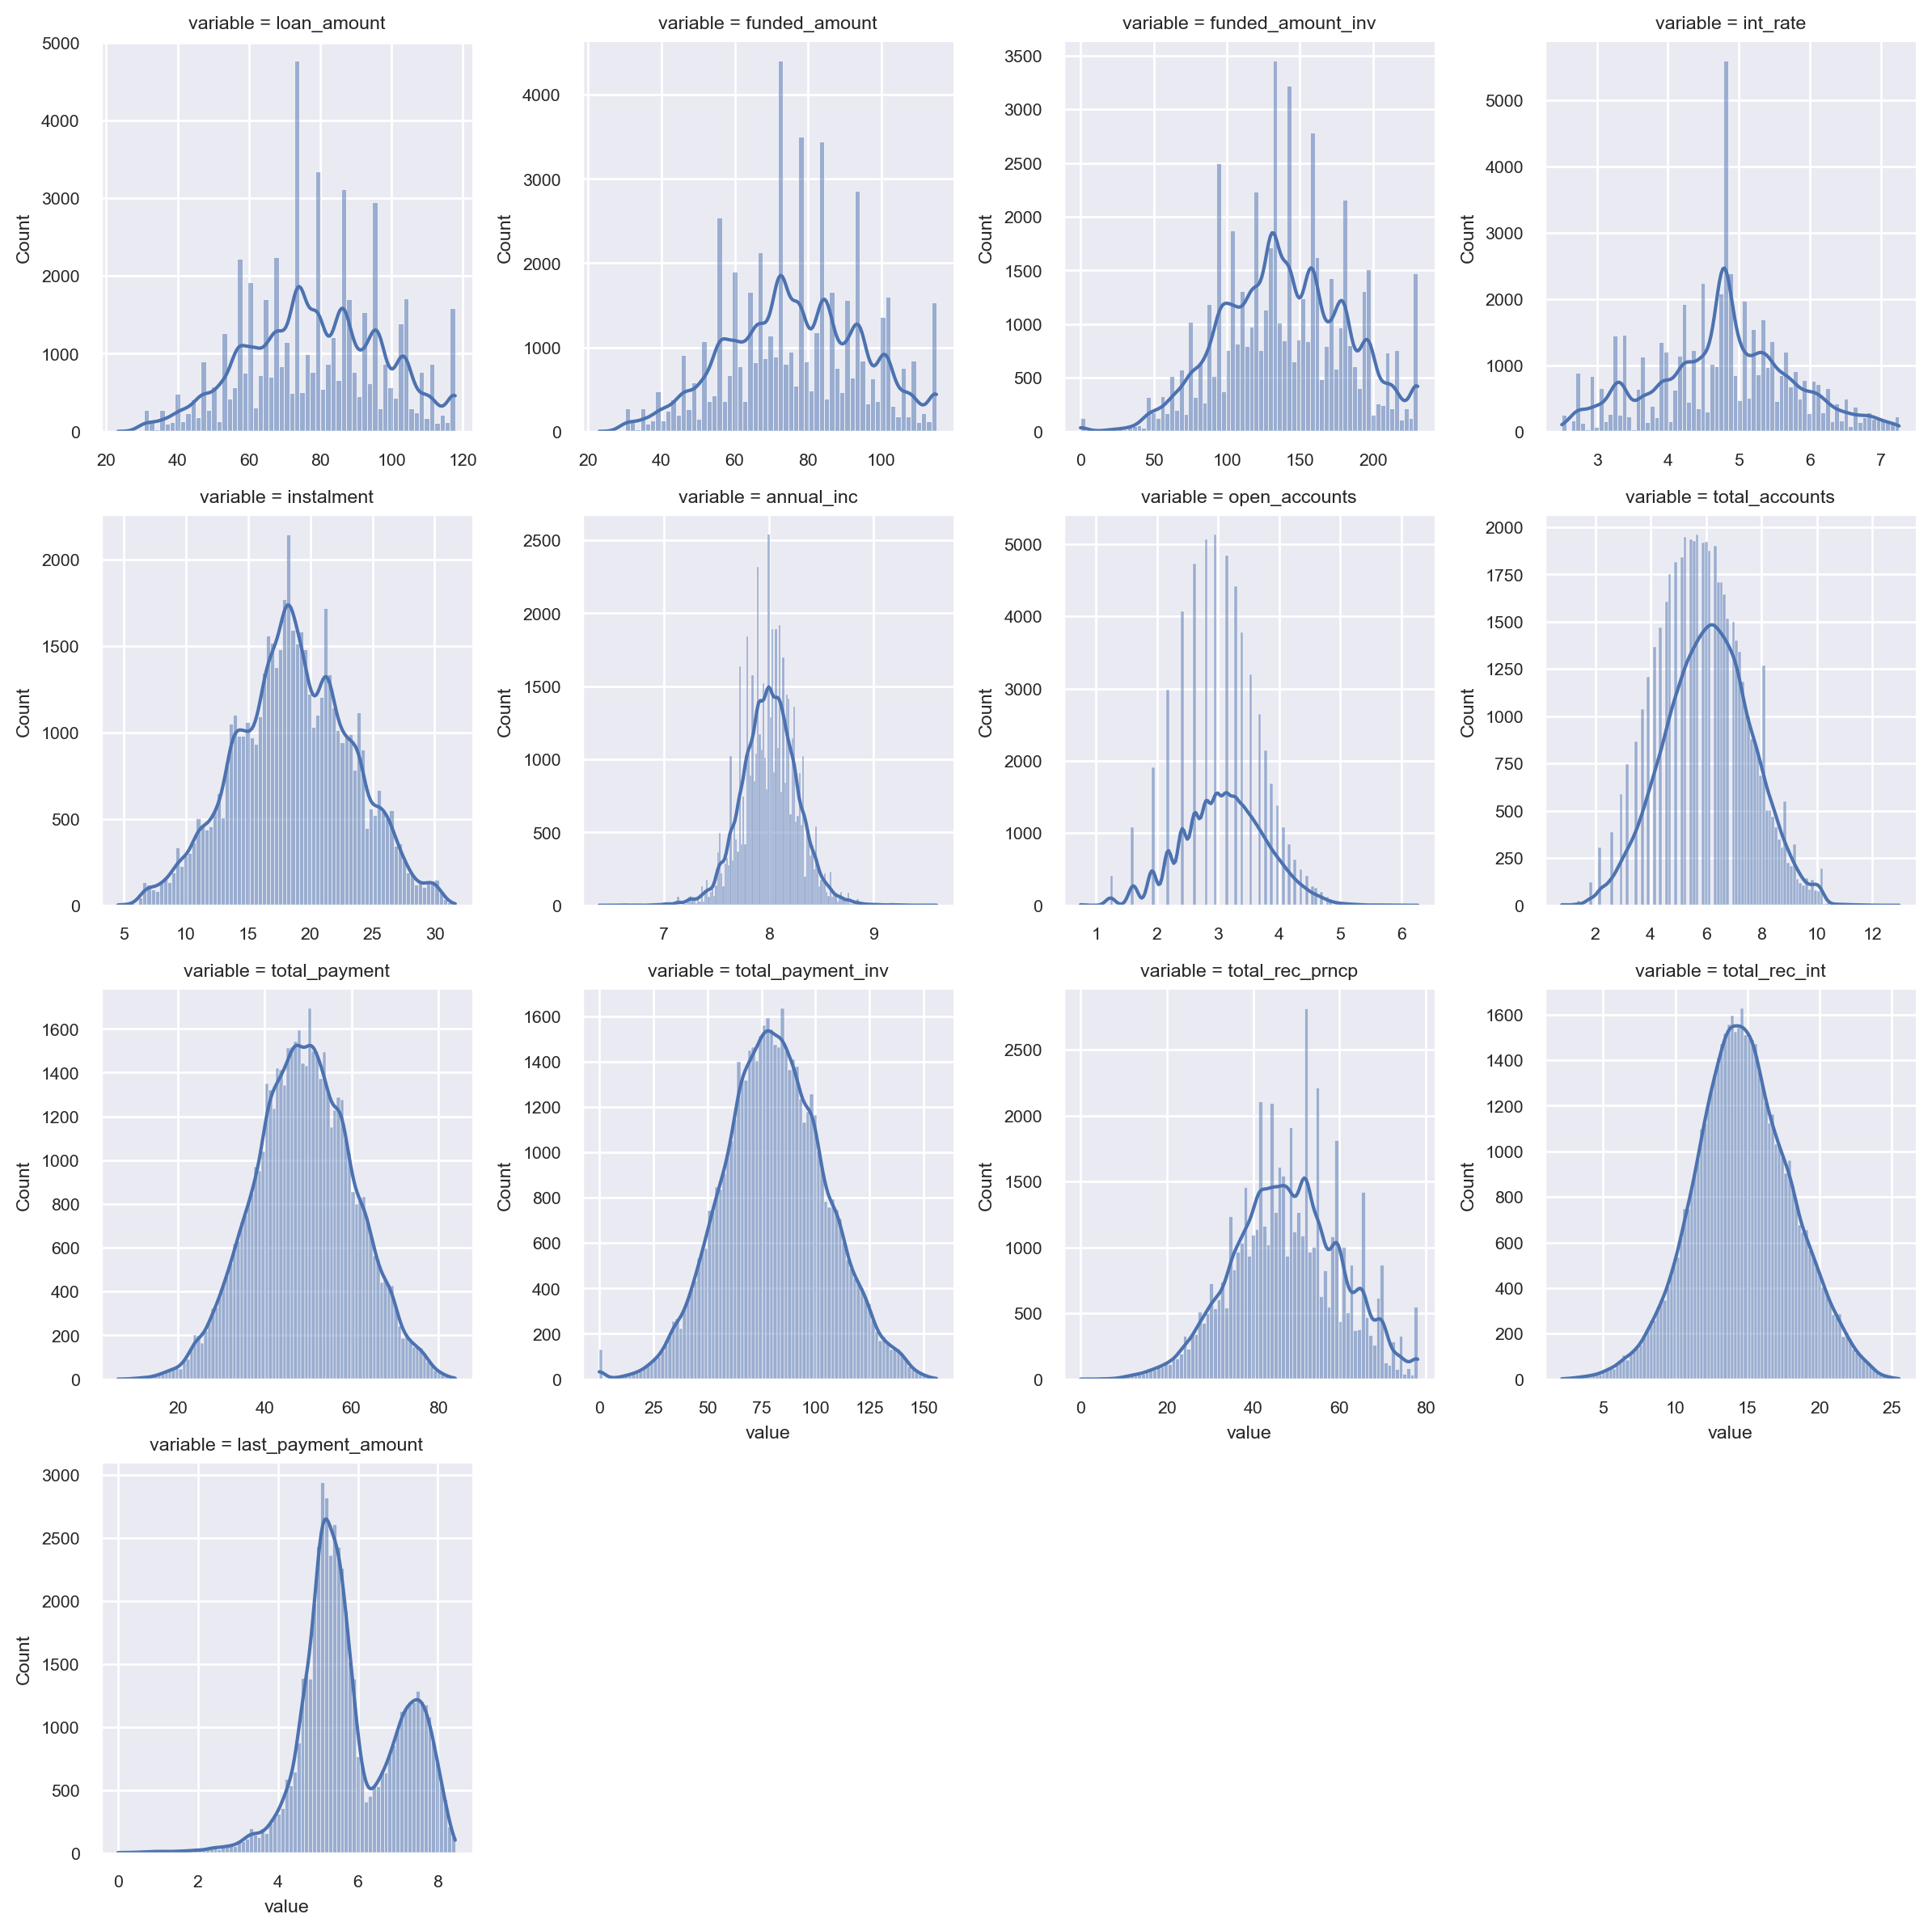

In [91]:
#Histograms after transforms
transformed_list = ['loan_amount', 'funded_amount', 'funded_amount_inv', 'int_rate','instalment', 'annual_inc', 'open_accounts', 
                    'total_accounts','total_payment', 'total_payment_inv', 'total_rec_prncp','total_rec_int', 'last_payment_amount']
                        
plot.histogram_grid(df, data = transformed_list, columns=4)

The plot shows good reslults for most of these columns, the only one that is showing skew is 'last_payment_amount'.

#### Task 5 Remove Outliers

We will first produce some boxplots of the columns of interest.

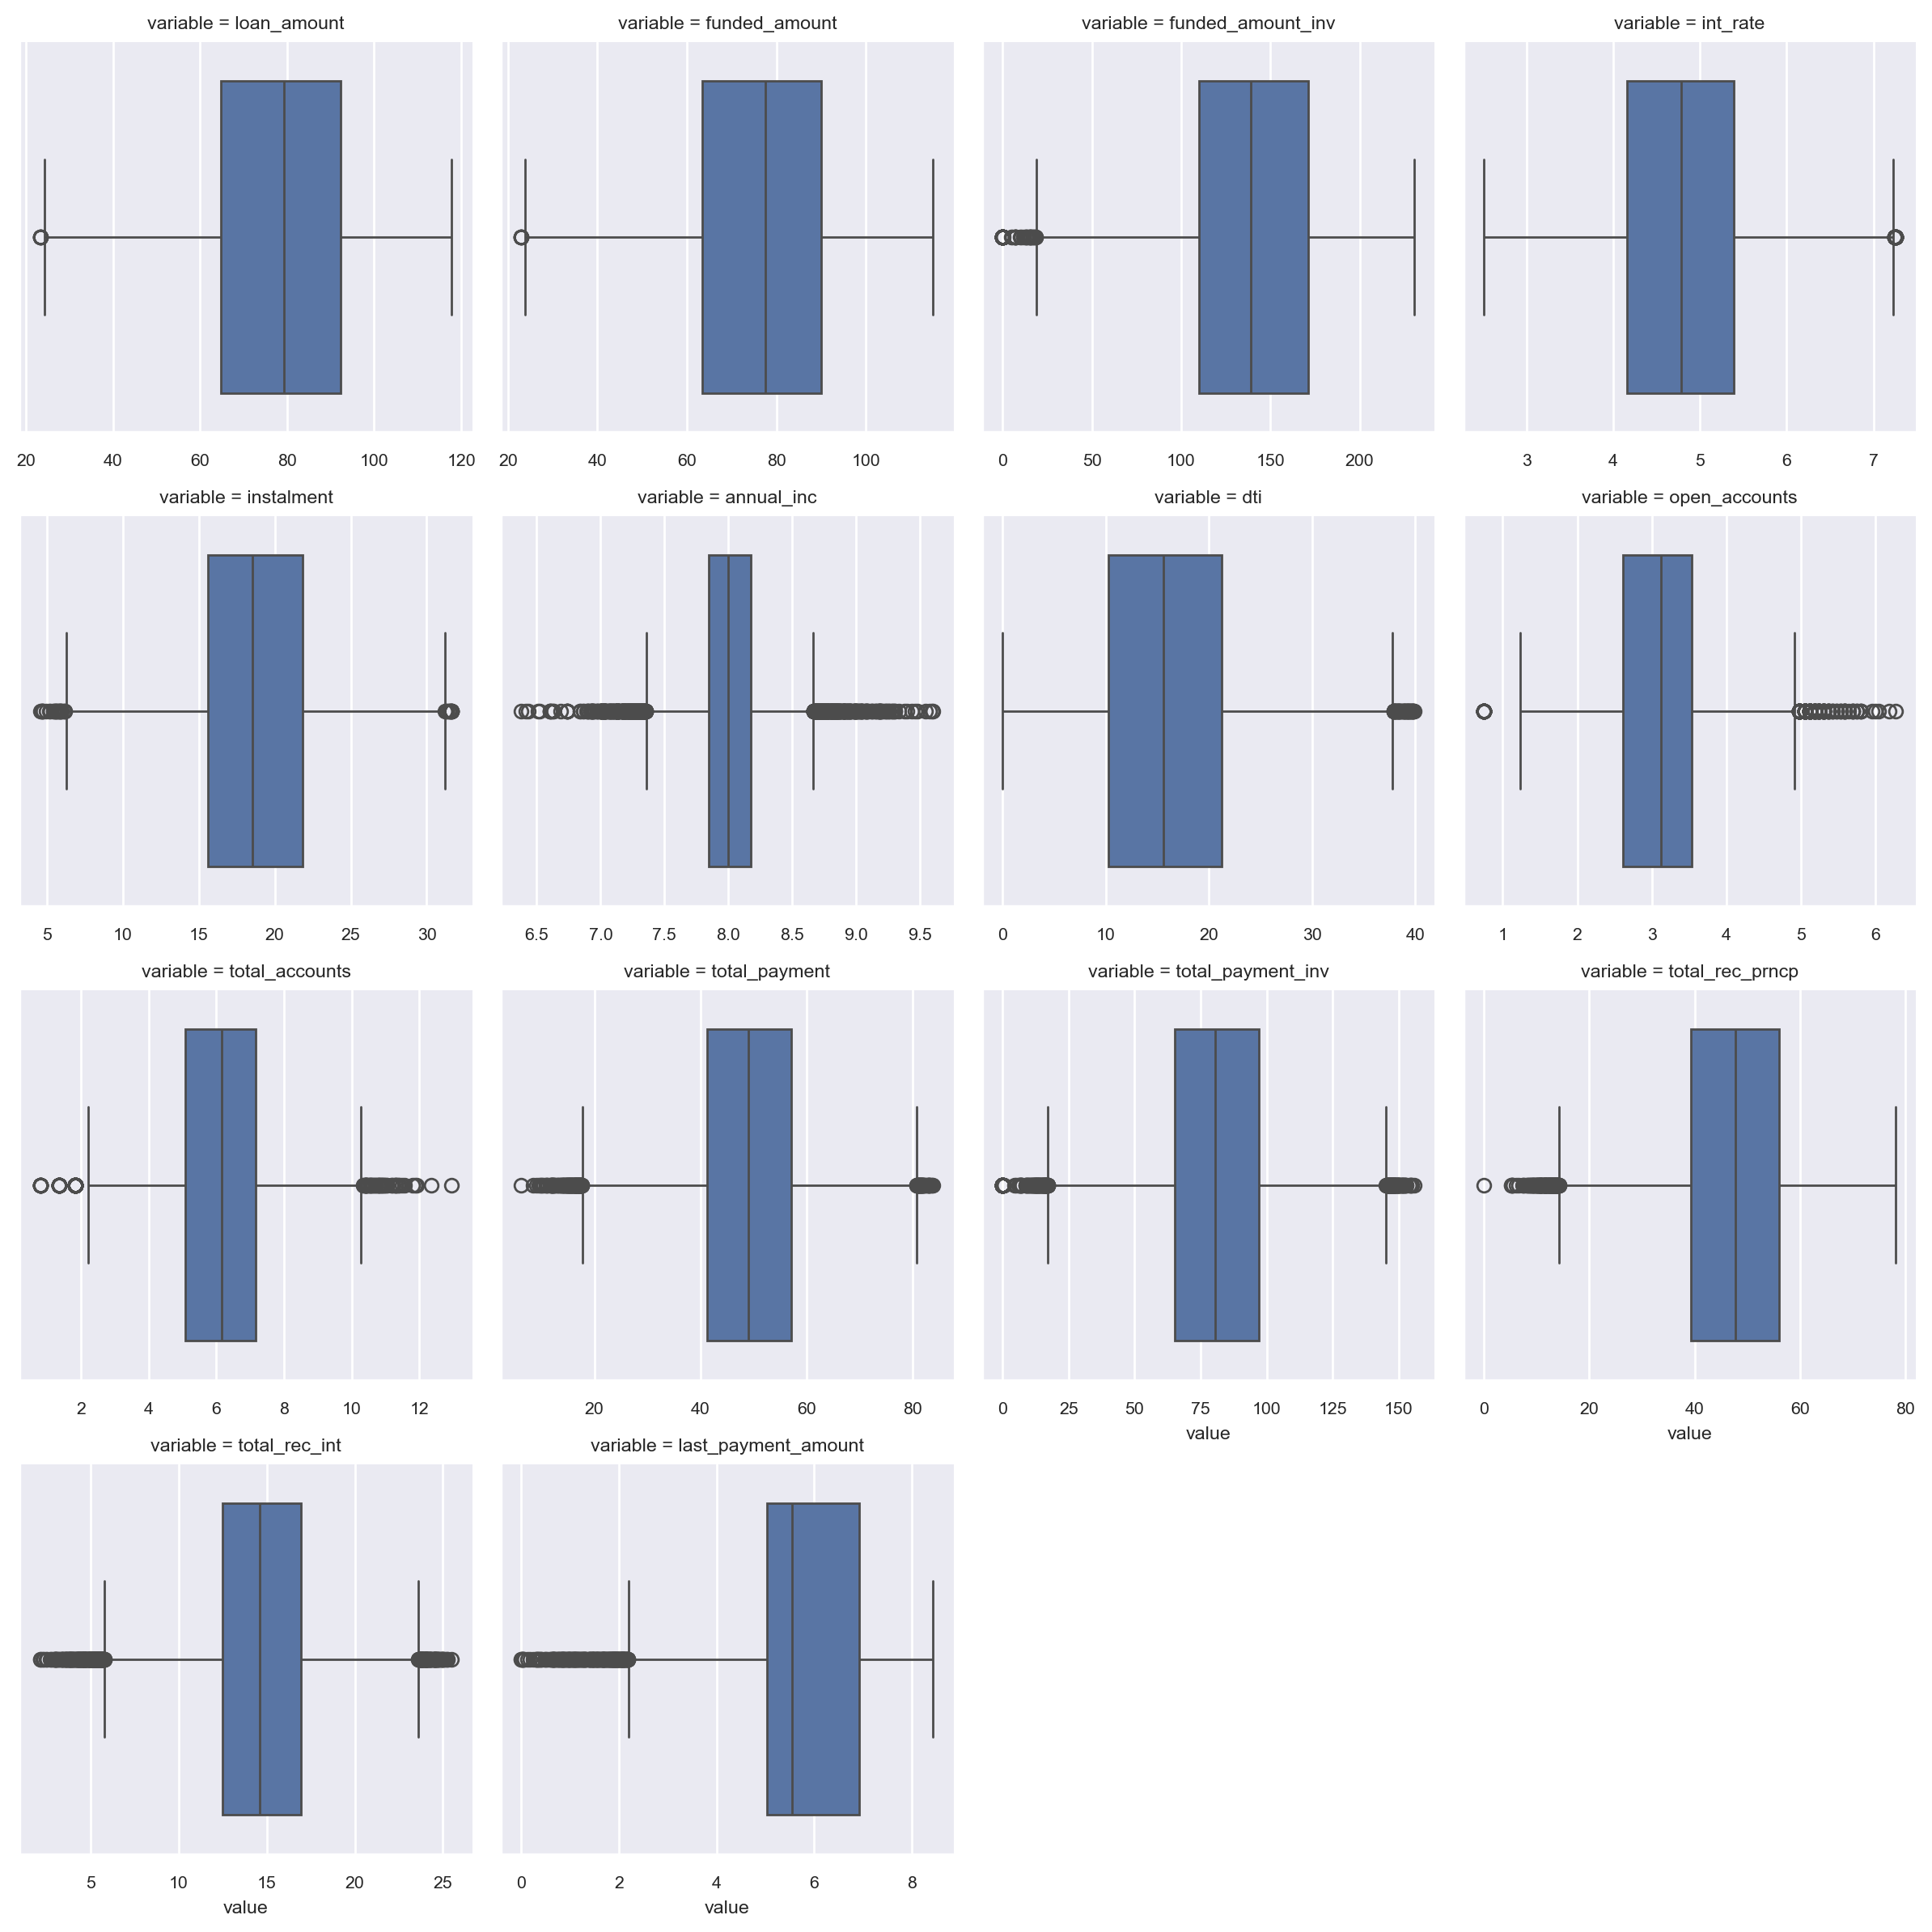

In [92]:
# Get columns
excluded = ['id', 'member_id', 'term', 'employment_length', 'delinq_2yrs', 'inq_last_6mths',
            'out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
            'collections_12_mths_ex_med', 'policy_code']

column_list_numeric = transform.get_numeric_columns(df, exclude=excluded)

#plot boxplots
plot.boxplot_grid(df[column_list_numeric], columns=4)


Let's examine the first two columns that appear to have either one or a few close value outliers.

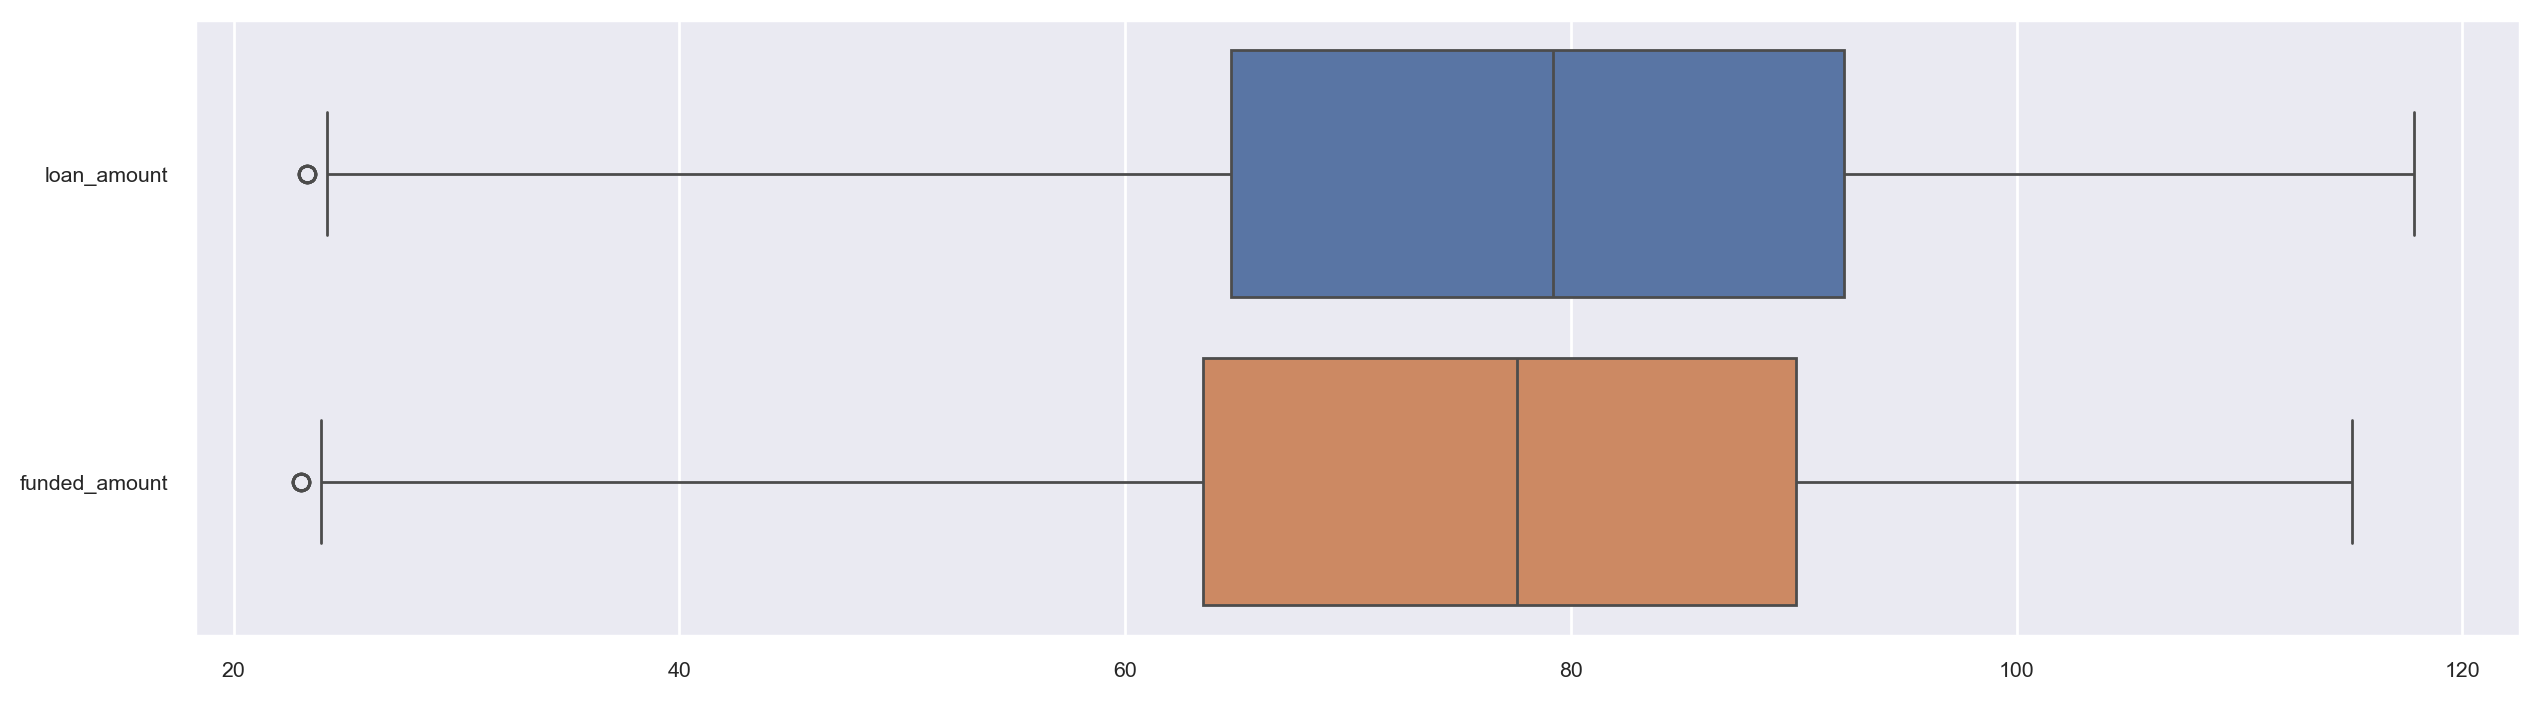

In [93]:
plot.plot_box(df, ['loan_amount', 'funded_amount'], fig_size=(15,4))

We will use the IQR to test for outliers in these two columns.

In [94]:
display(df_transform.iqr_outlier_test(df, 'loan_amount'))
display(df_transform.iqr_outlier_test(df, 'funded_amount'))

There are 6 outliers in loan_amount.


53352    23.296515
53470    23.296515
53709    23.296515
53843    23.296515
53849    23.296515
54056    23.296515
Name: loan_amount, dtype: float64

There are 6 outliers in funded_amount.


53352    23.00371
53470    23.00371
53709    23.00371
53843    23.00371
53849    23.00371
54056    23.00371
Name: funded_amount, dtype: float64

We see that using this test each column has six outliers all of the same value. Let's try a z-score test with a threshold of 3 and see what results we yield.

In [95]:
display(df_transform.zscore_test(df, 'loan_amount', 3))
display(df_transform.zscore_test(df, 'funded_amount', 3))

Series([], Name: loan_amount, dtype: float64)

Series([], Name: funded_amount, dtype: float64)

Using the z-score test no values are deemed to be outliers. I'm inclined to go with the z-score results and not remove any of these rows with outliers in these columns. I will now apply the z-score test to the remaining columns and remove any rows with identified outliers.

In [96]:
#remove 'loan_amount' and 'funded_amount' from the required column list
#new_column_list = column_list_numeric.copy()
for name in column_list_numeric:
    if name in ['loan_amount', 'funded_amount']:
        column_list_numeric.remove(name)

#Make a copy of the dataframe so we can compare
df_copy = df.copy()

for column in column_list_numeric:
     df = df_transform.drop_outliers_zscore(df, column, 3)

no_removed = df_copy.shape[0] - df.shape[0]
print(f'{no_removed} columns where removed')


1184 columns where removed


Below are comparison plots of the data before and after outlier removal. Unfortunately I could not use one plot for comparisons  as the changes were hard to see in a small plot, so I had to produce a seperate plot for each column.

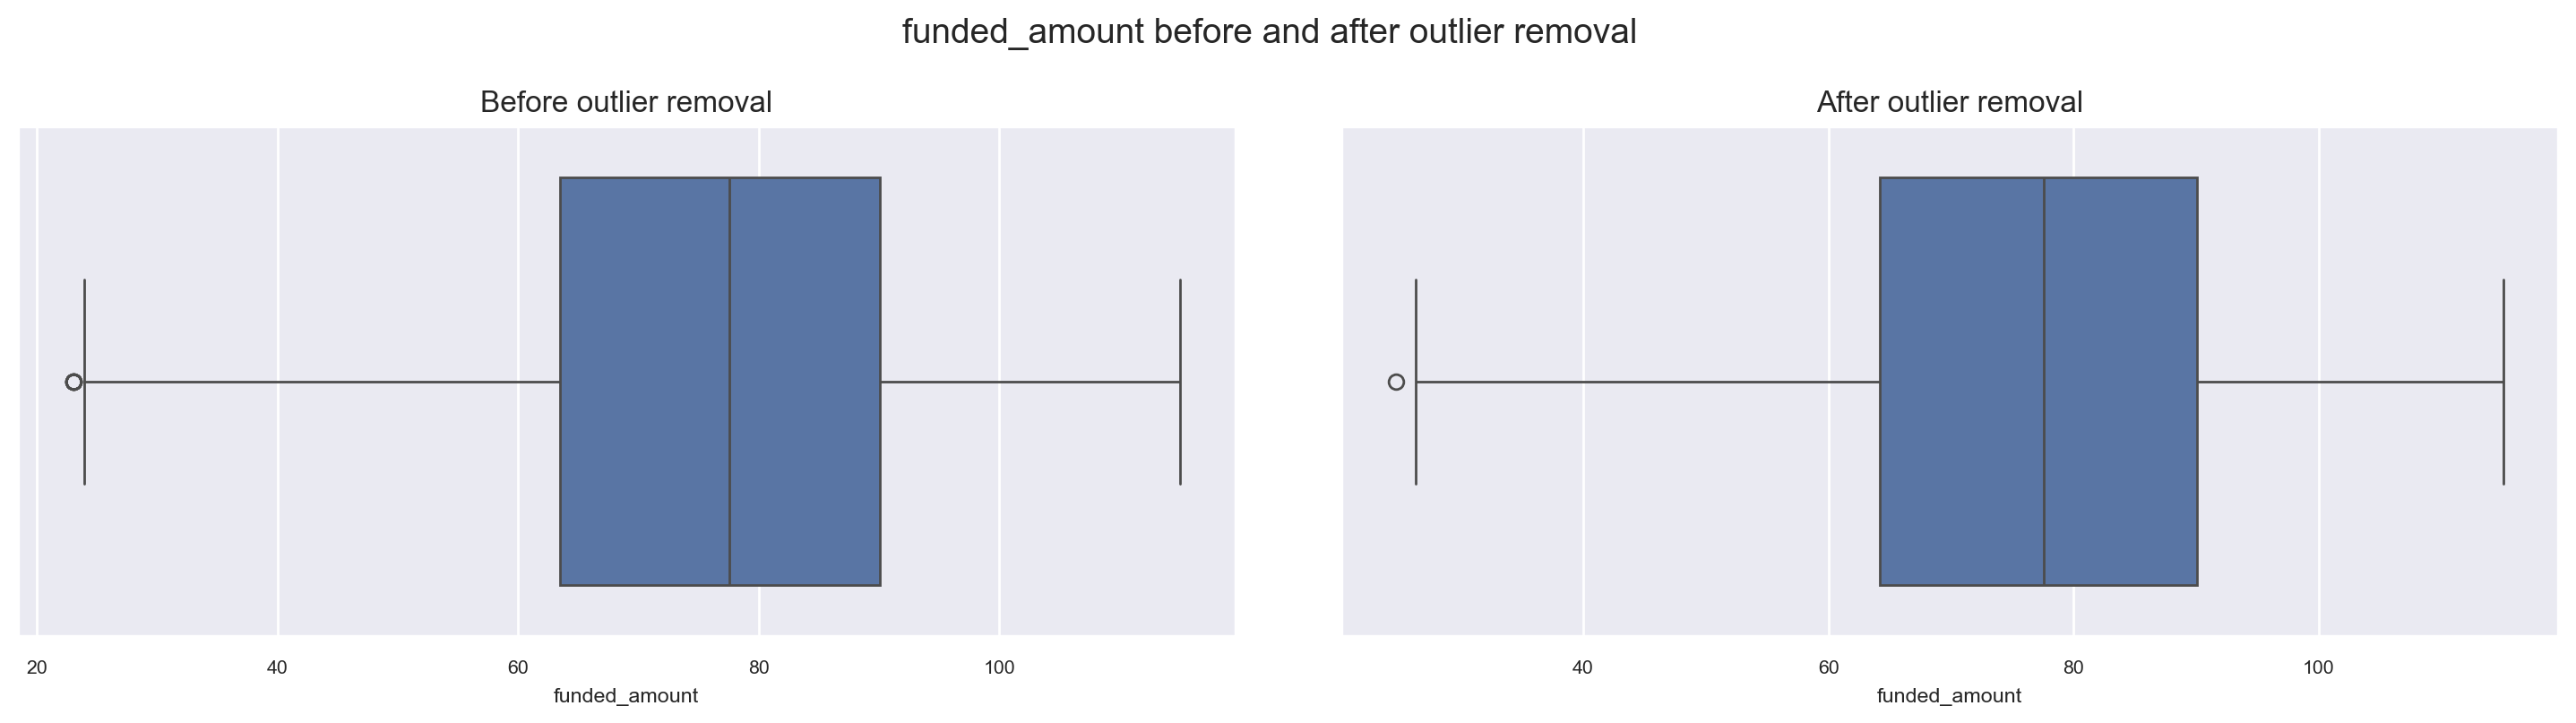

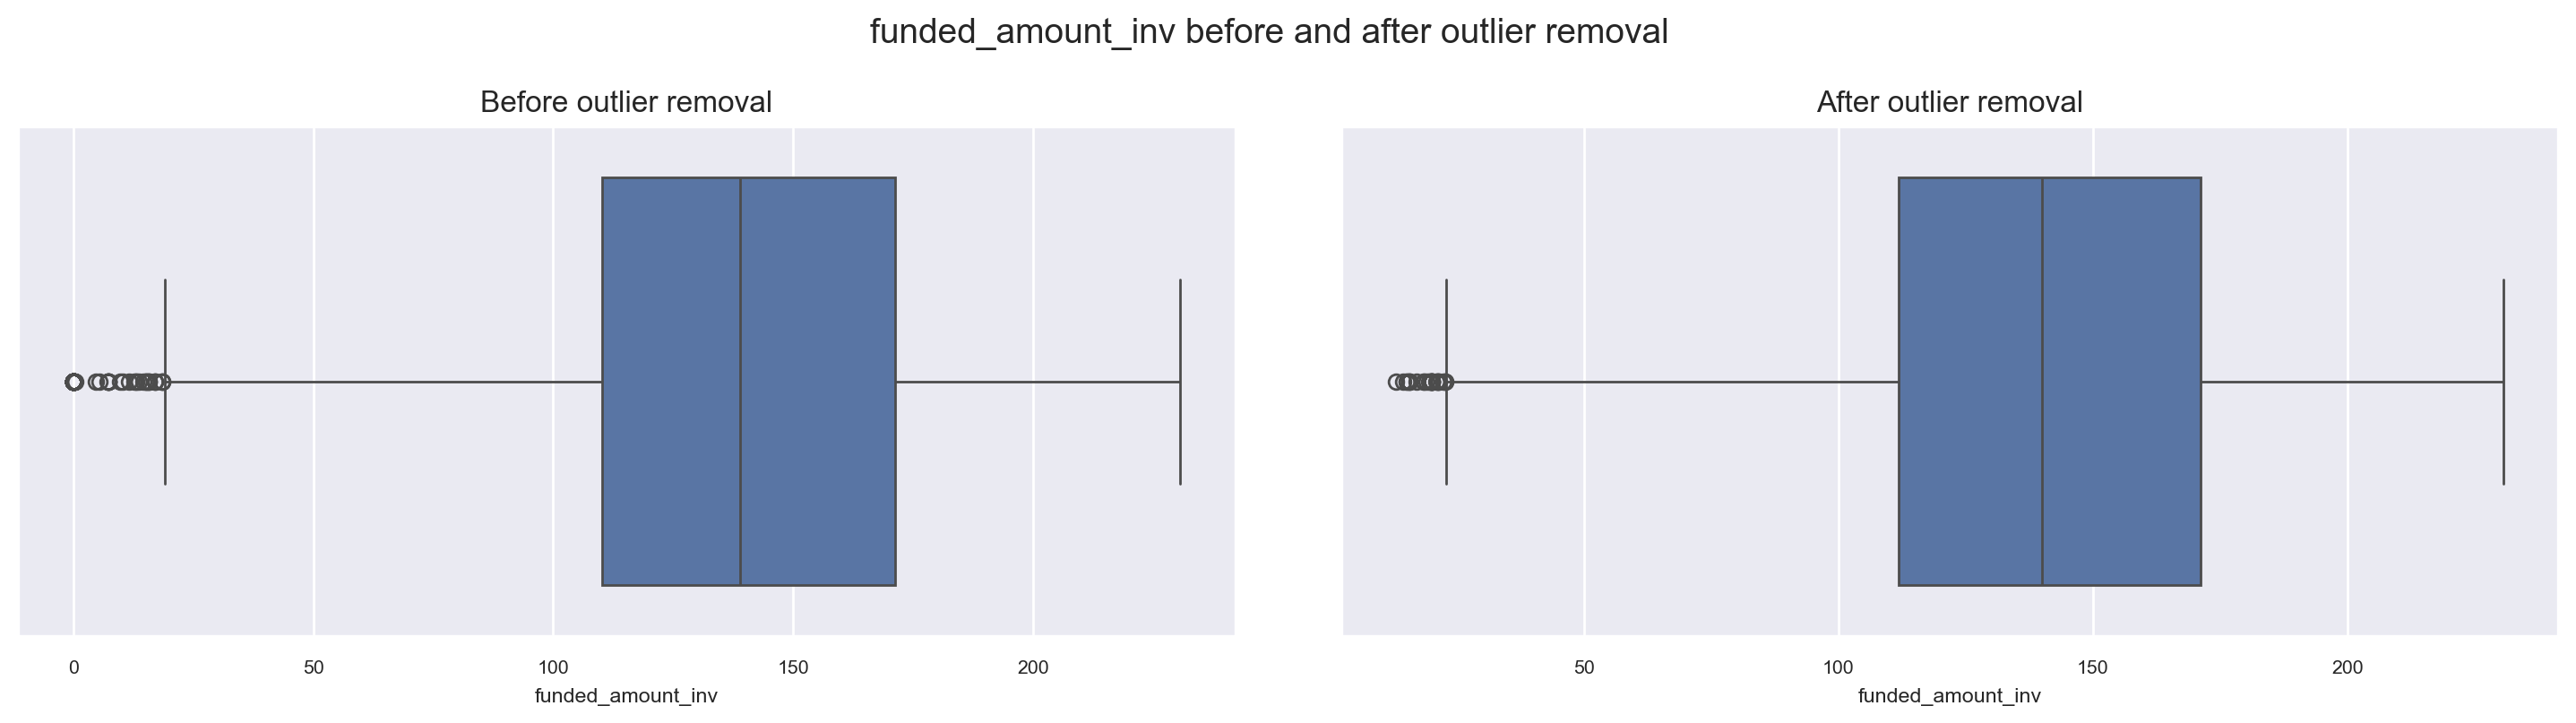

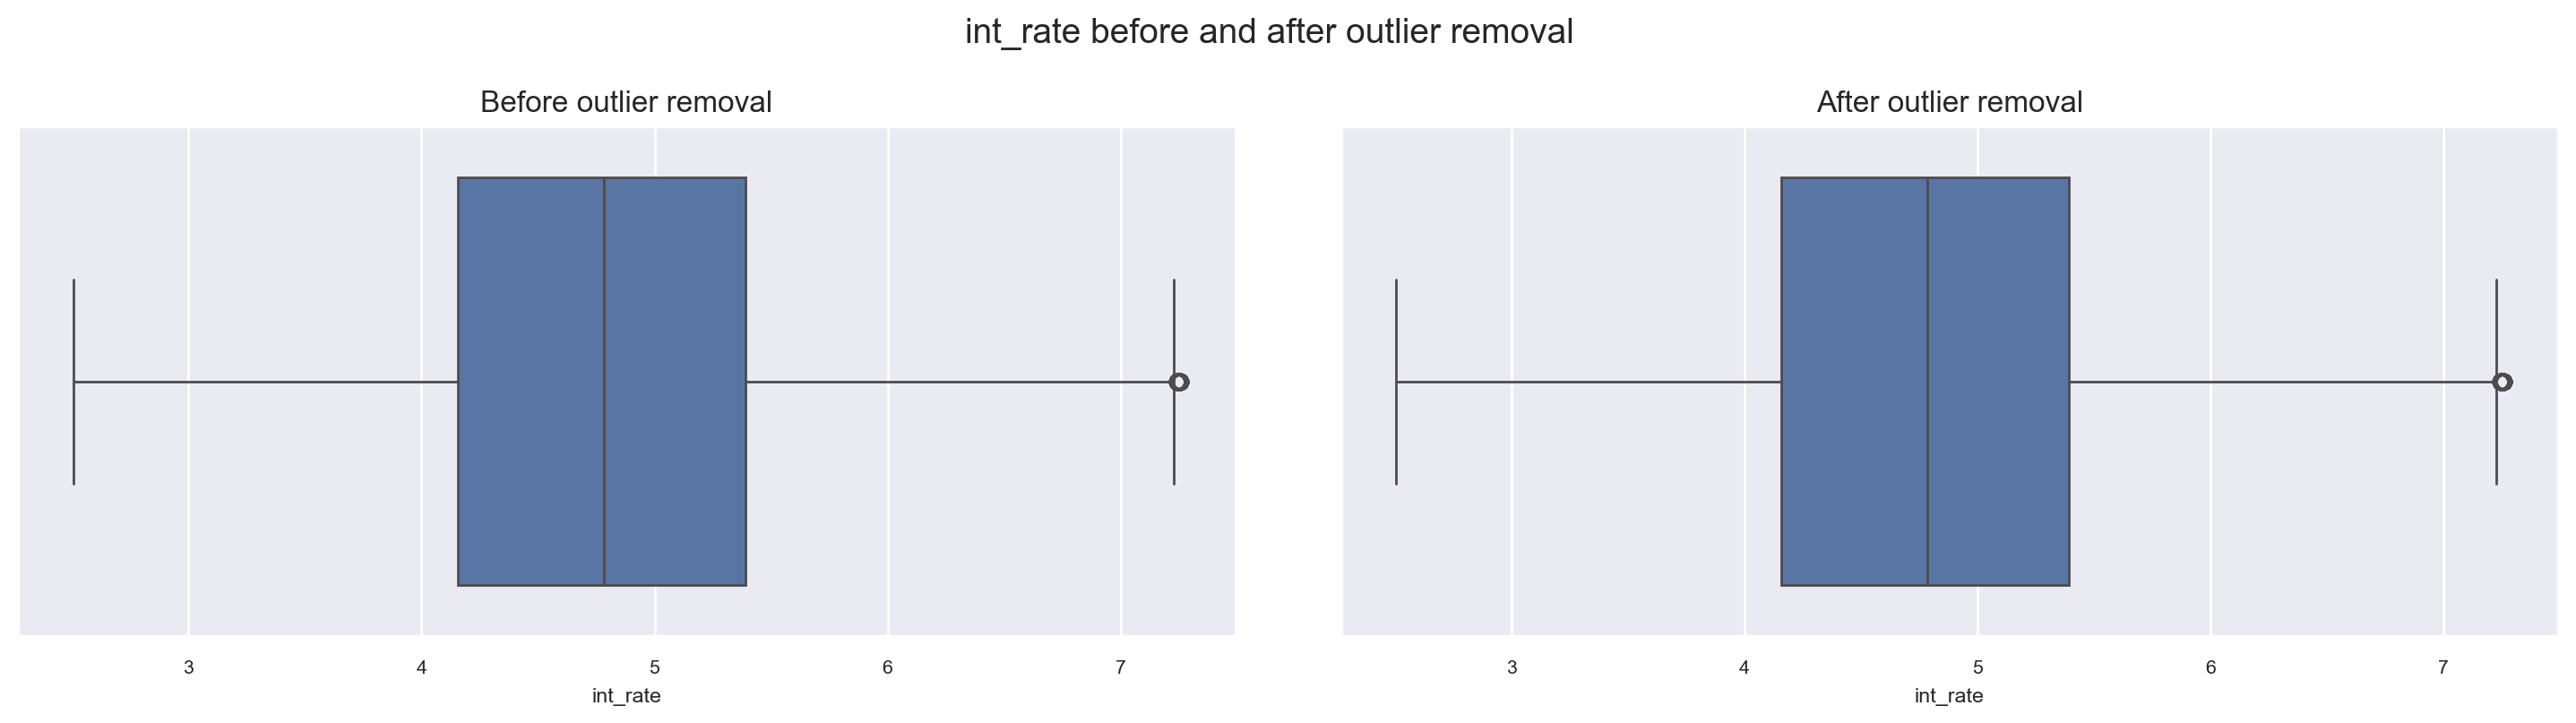

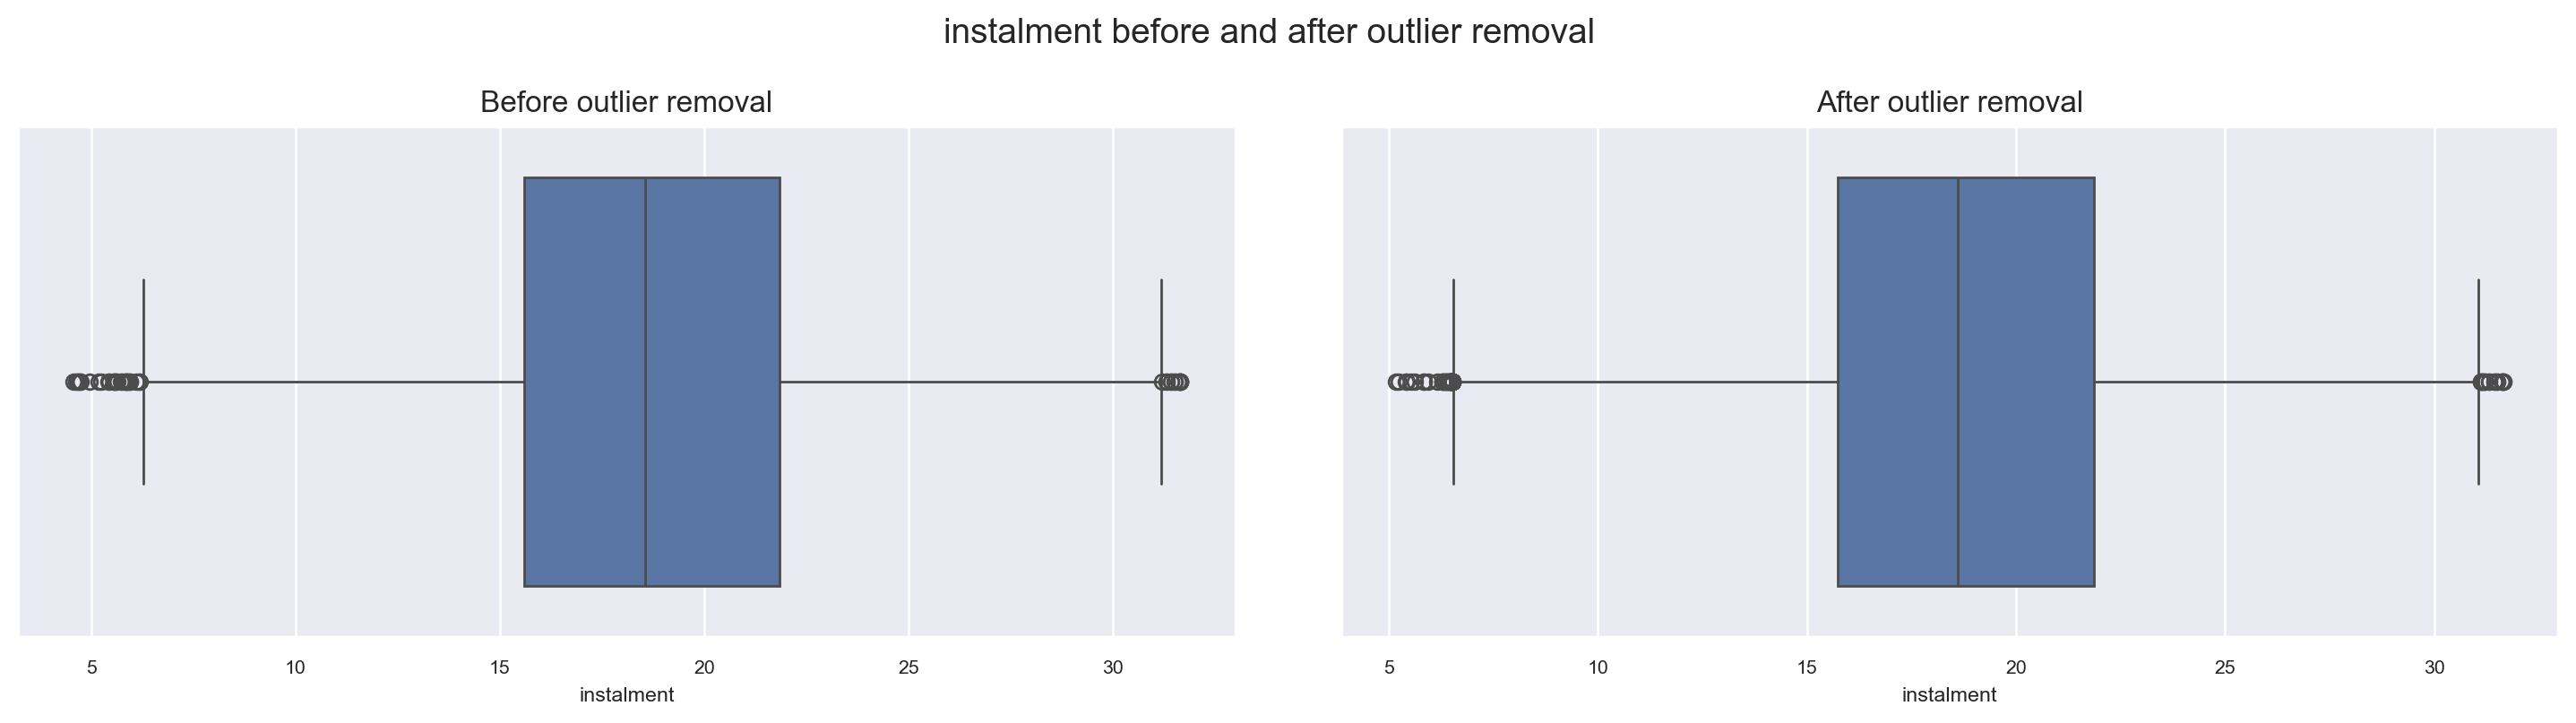

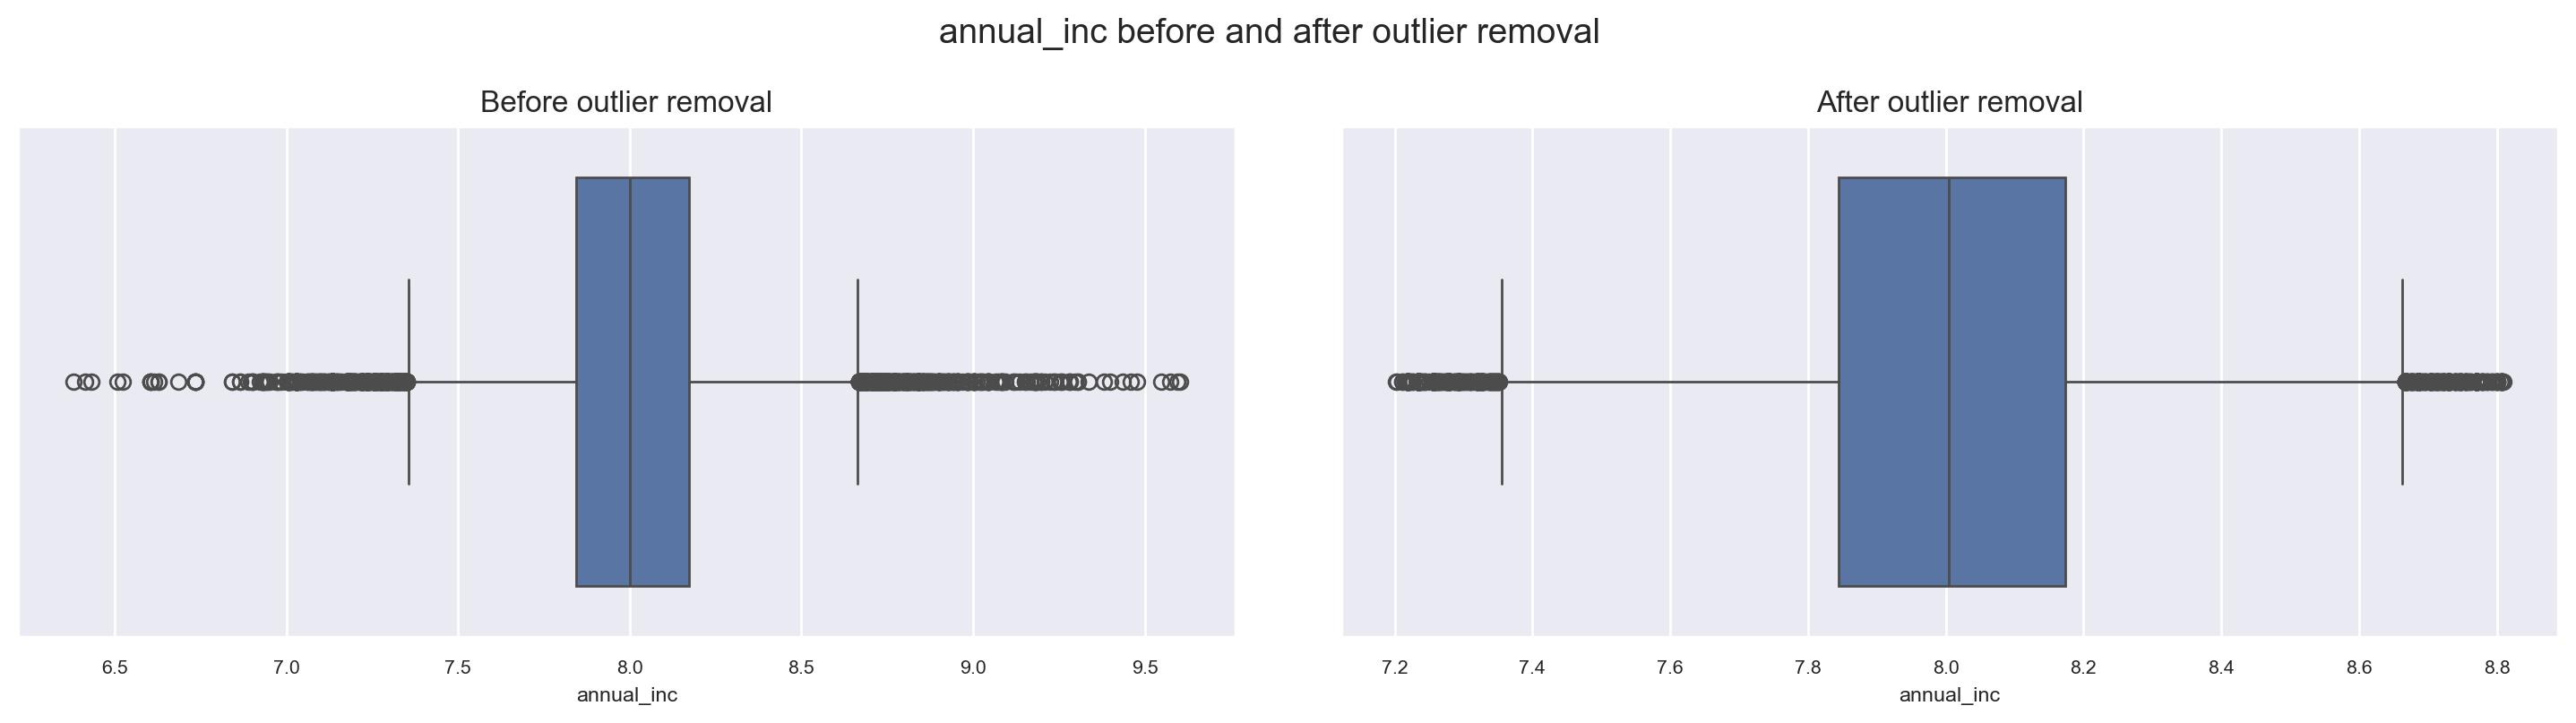

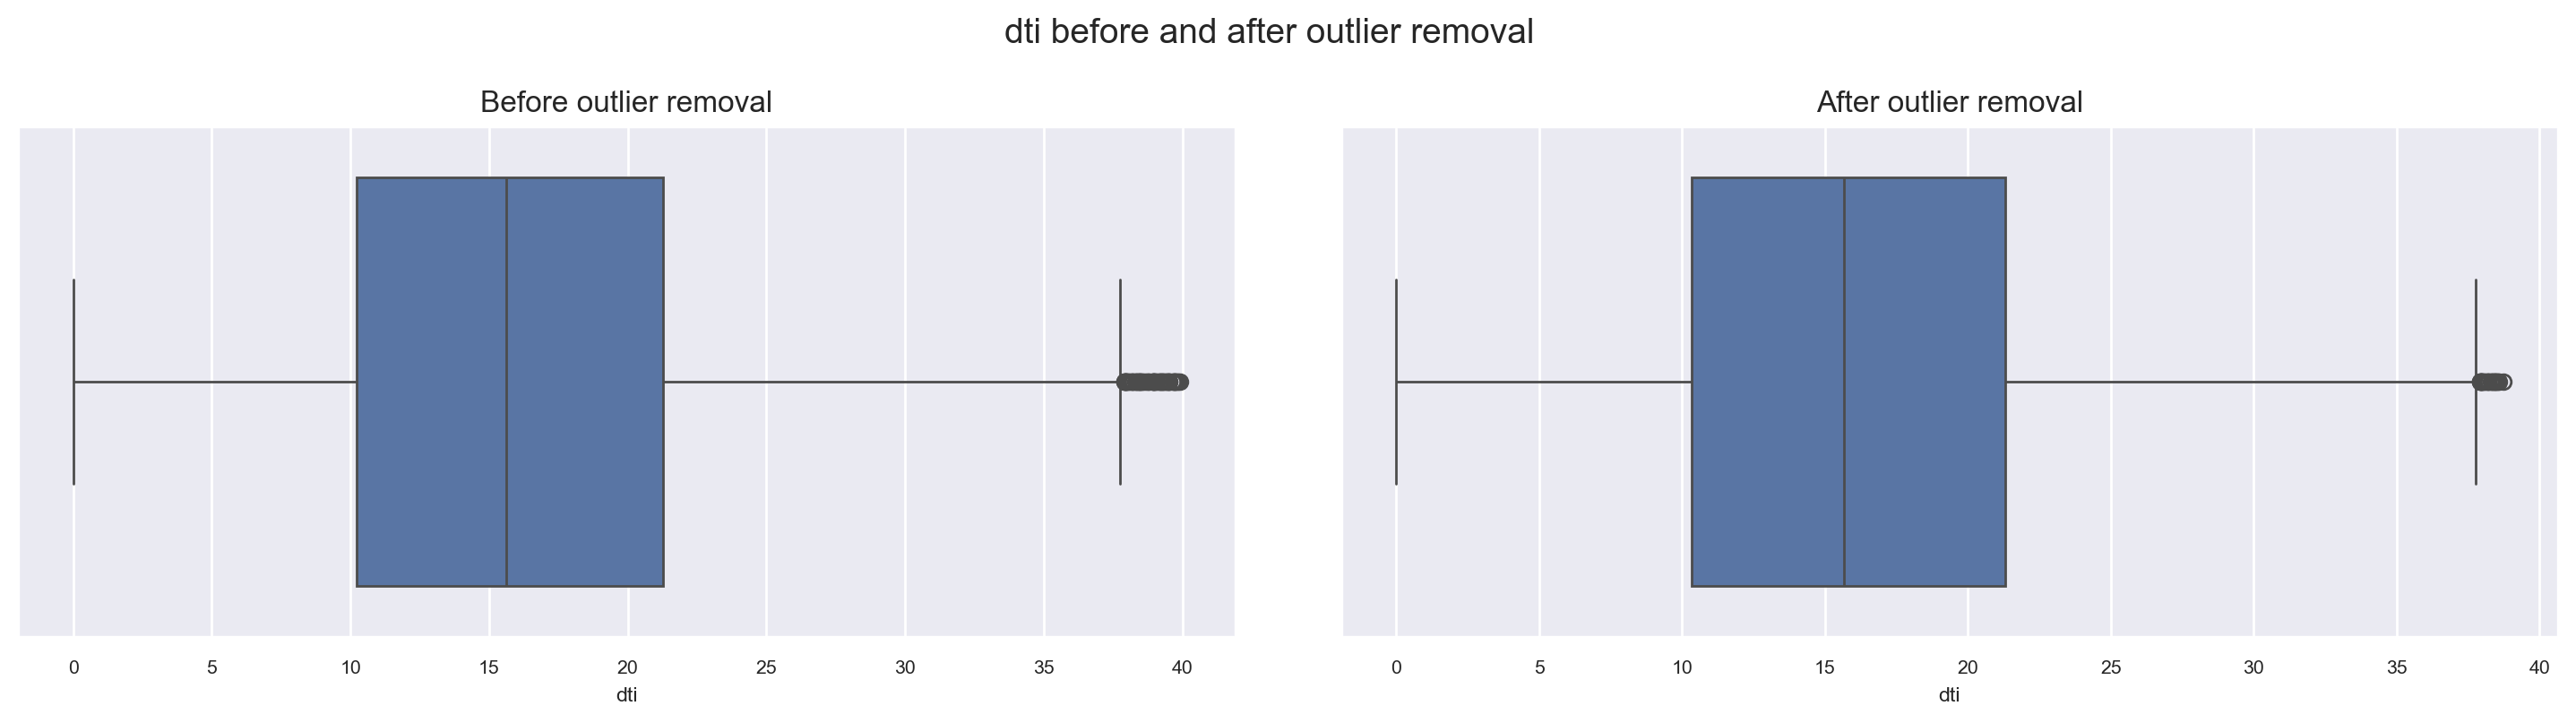

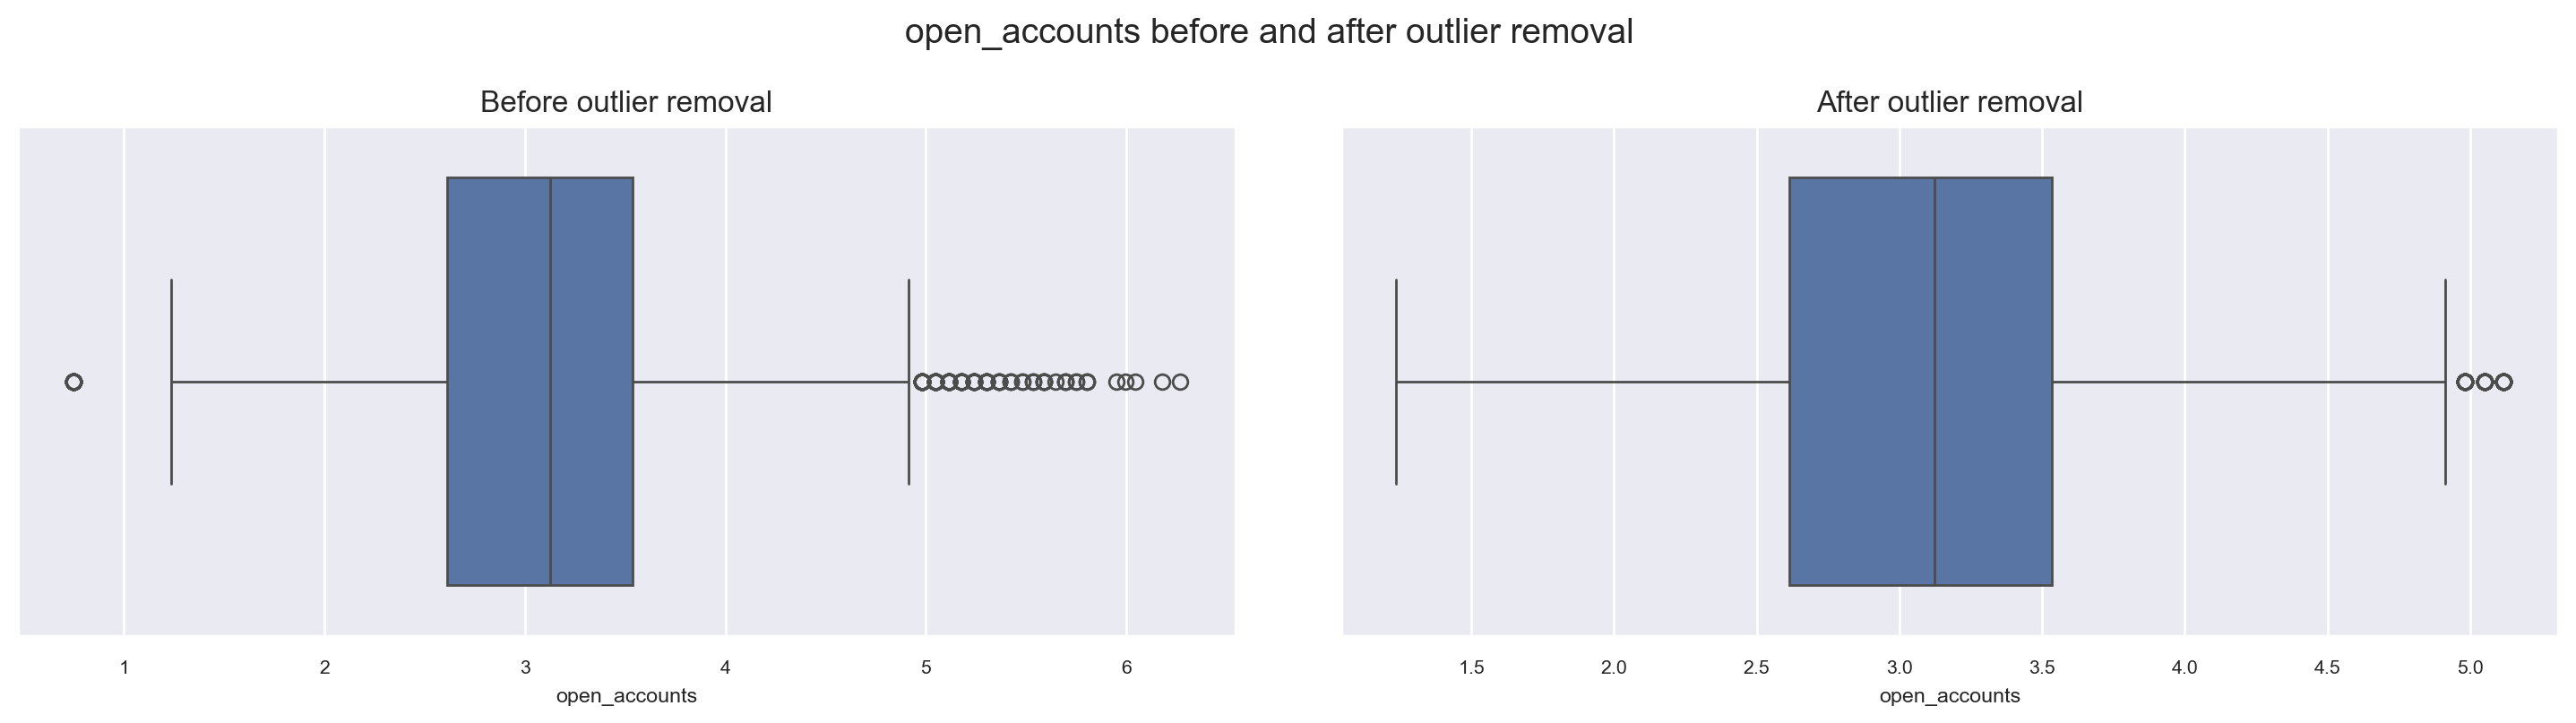

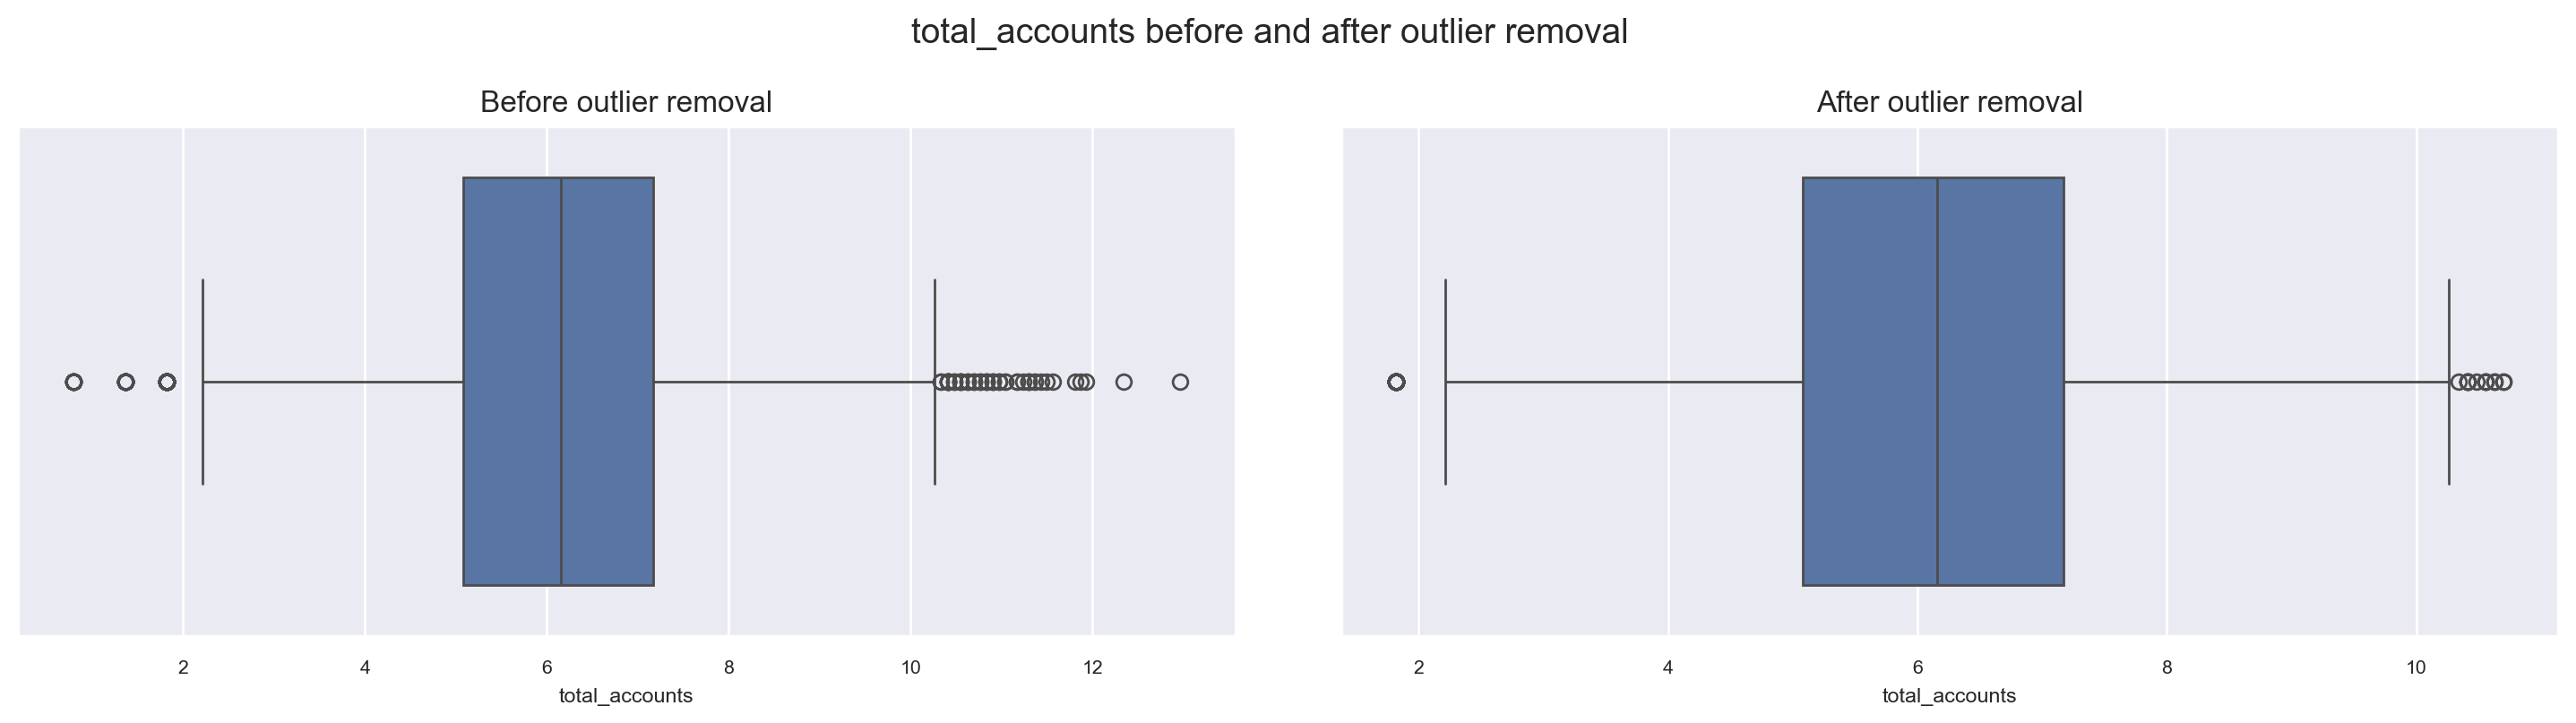

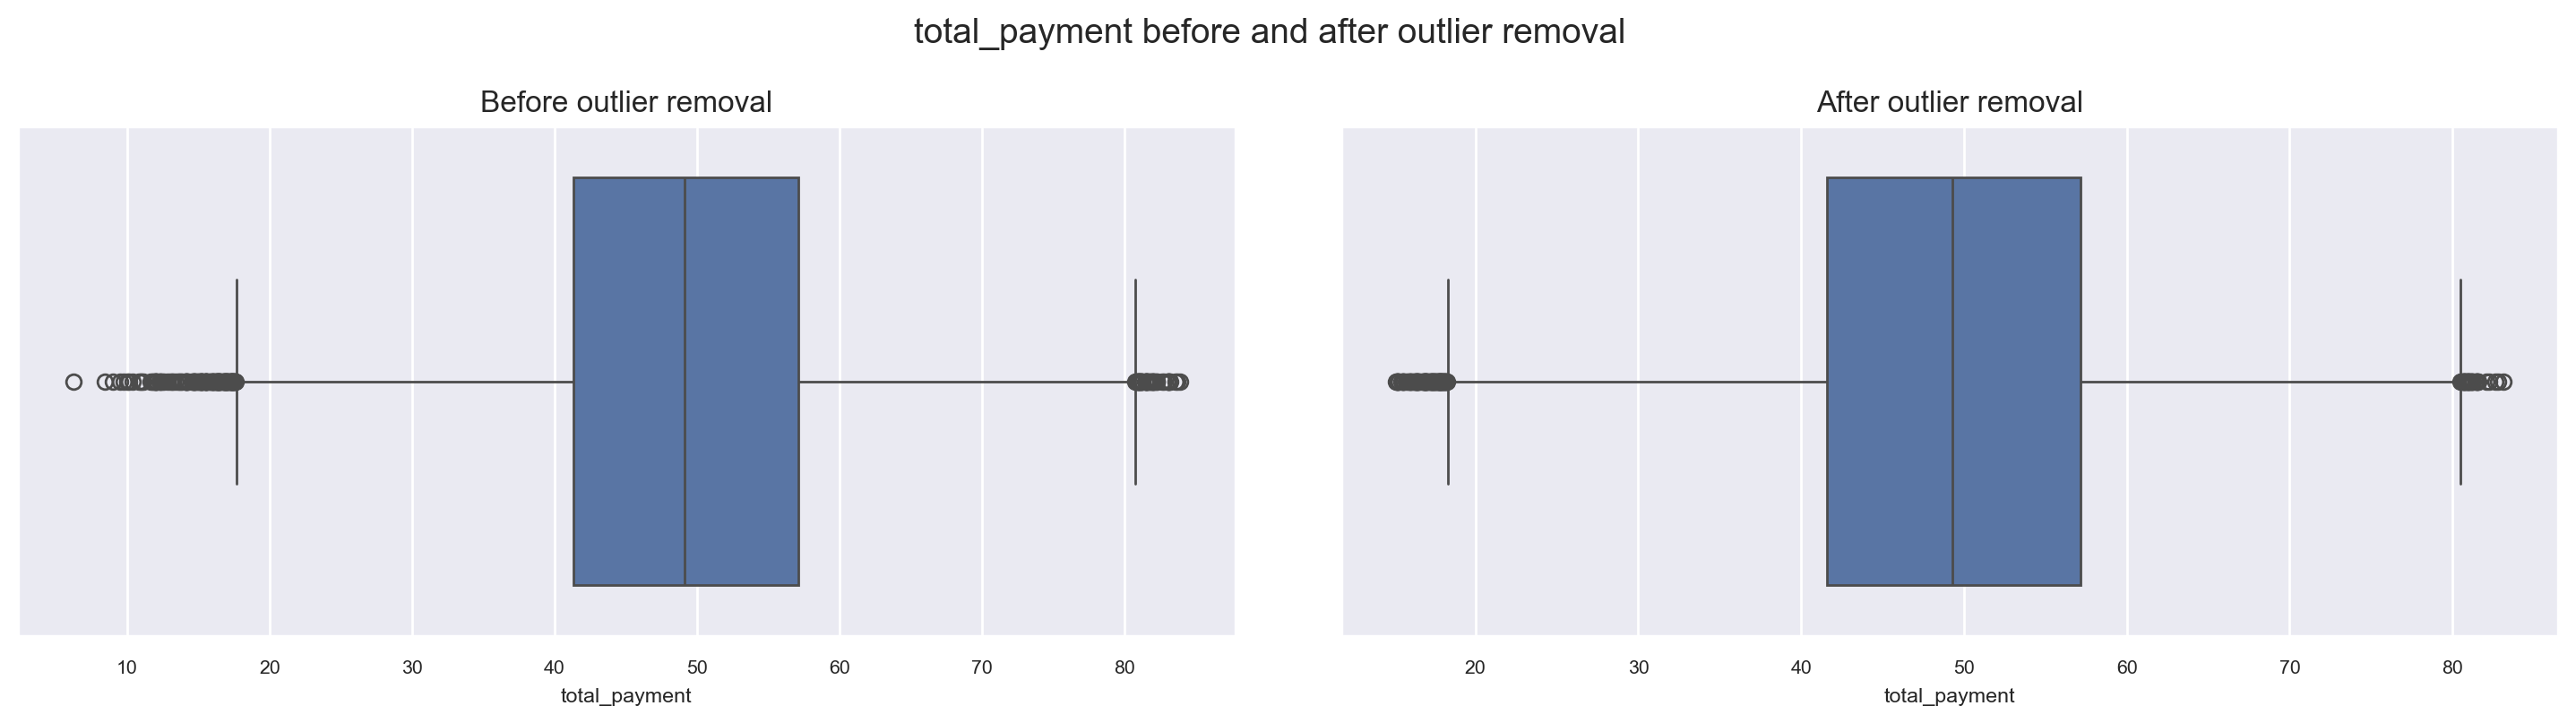

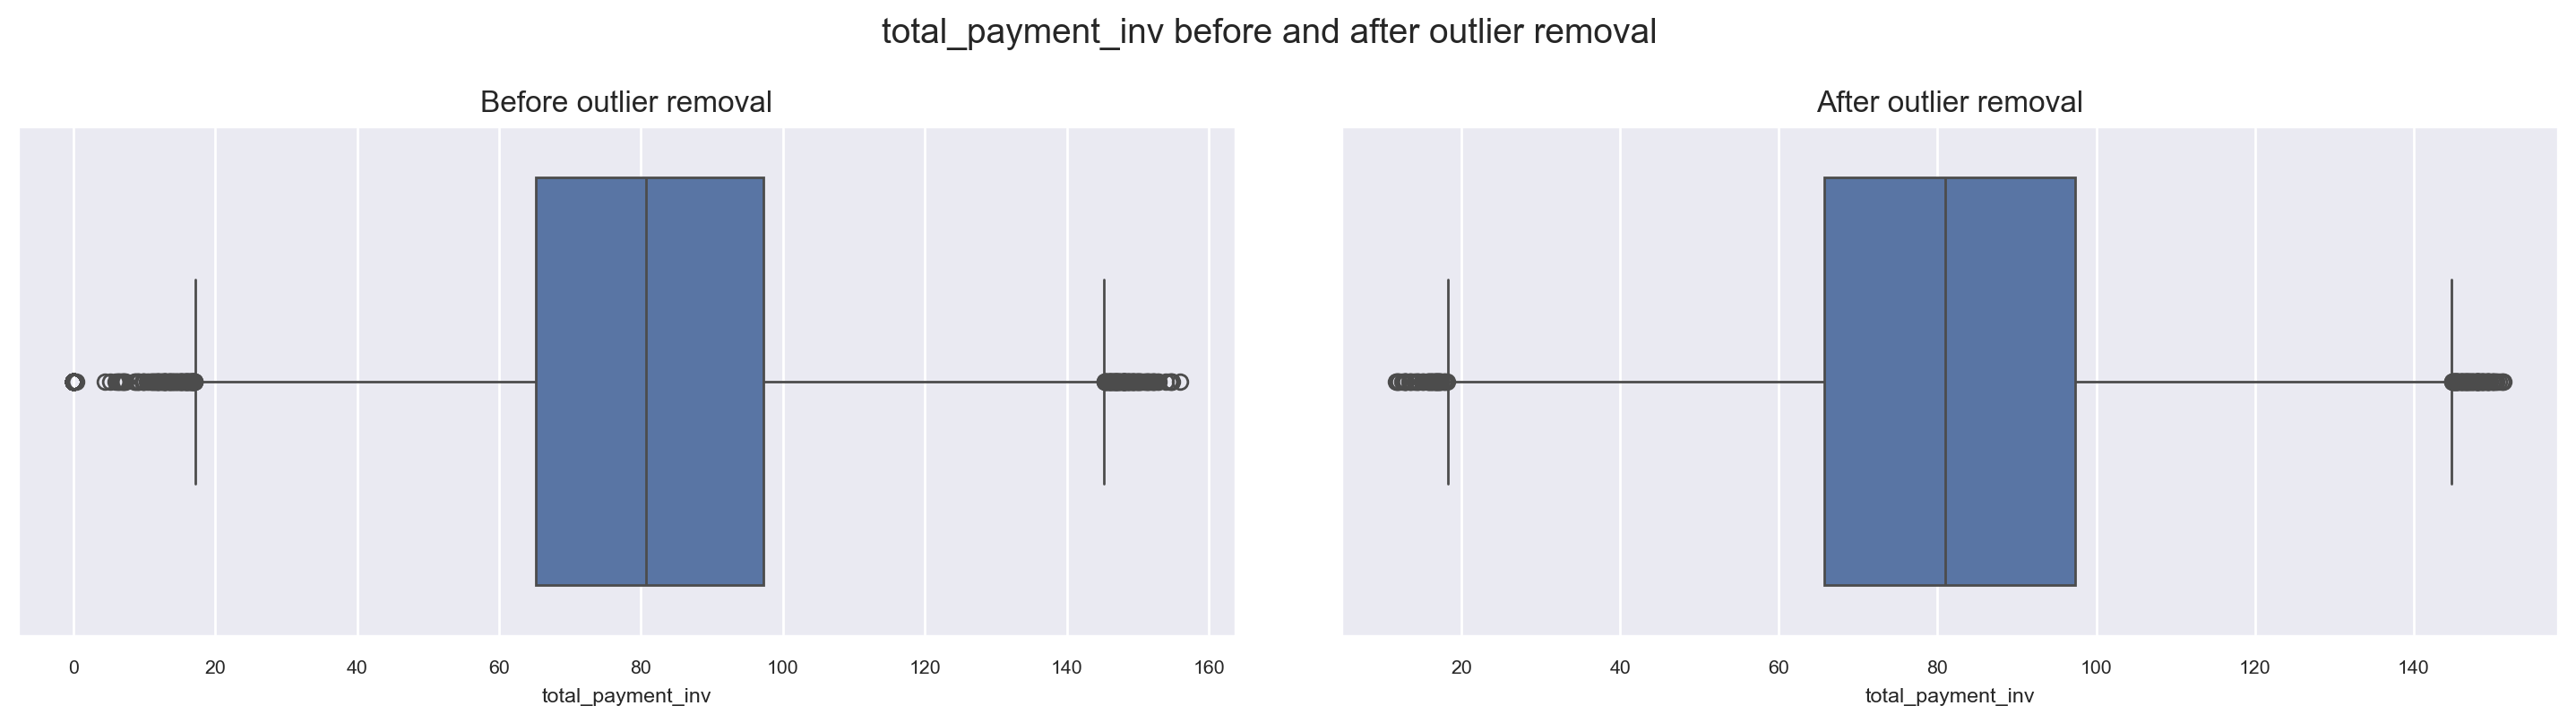

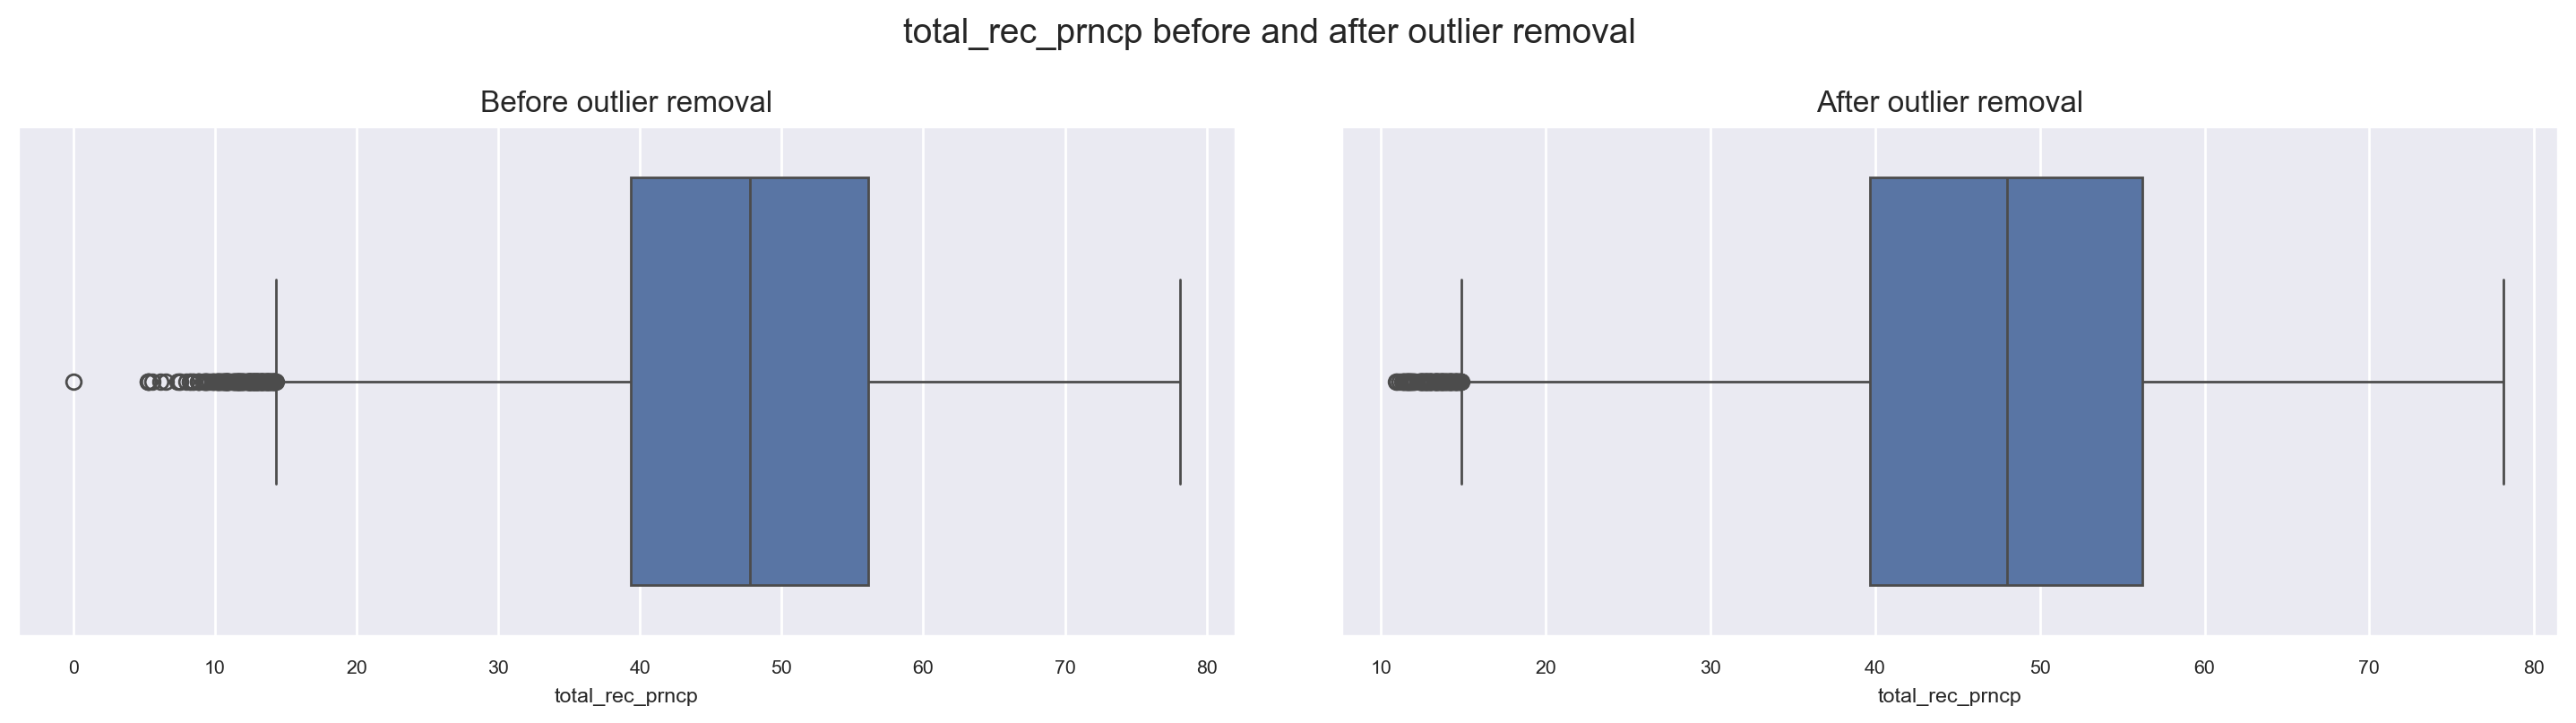

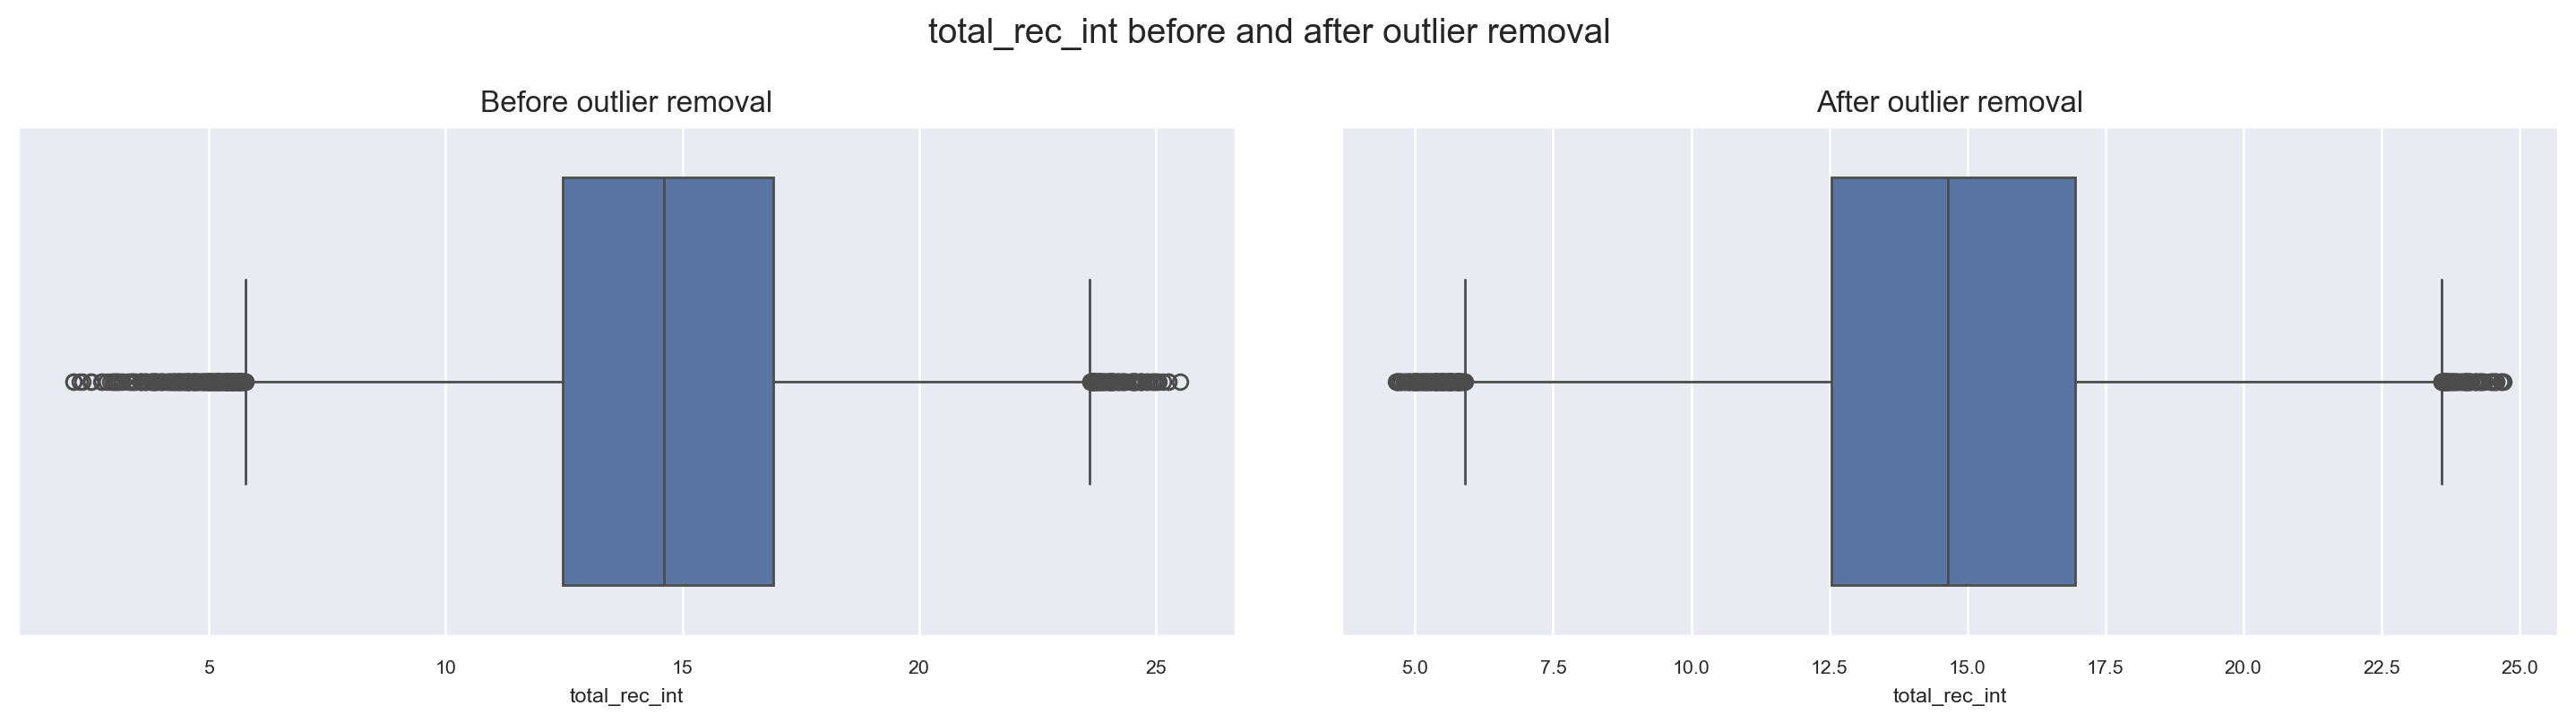

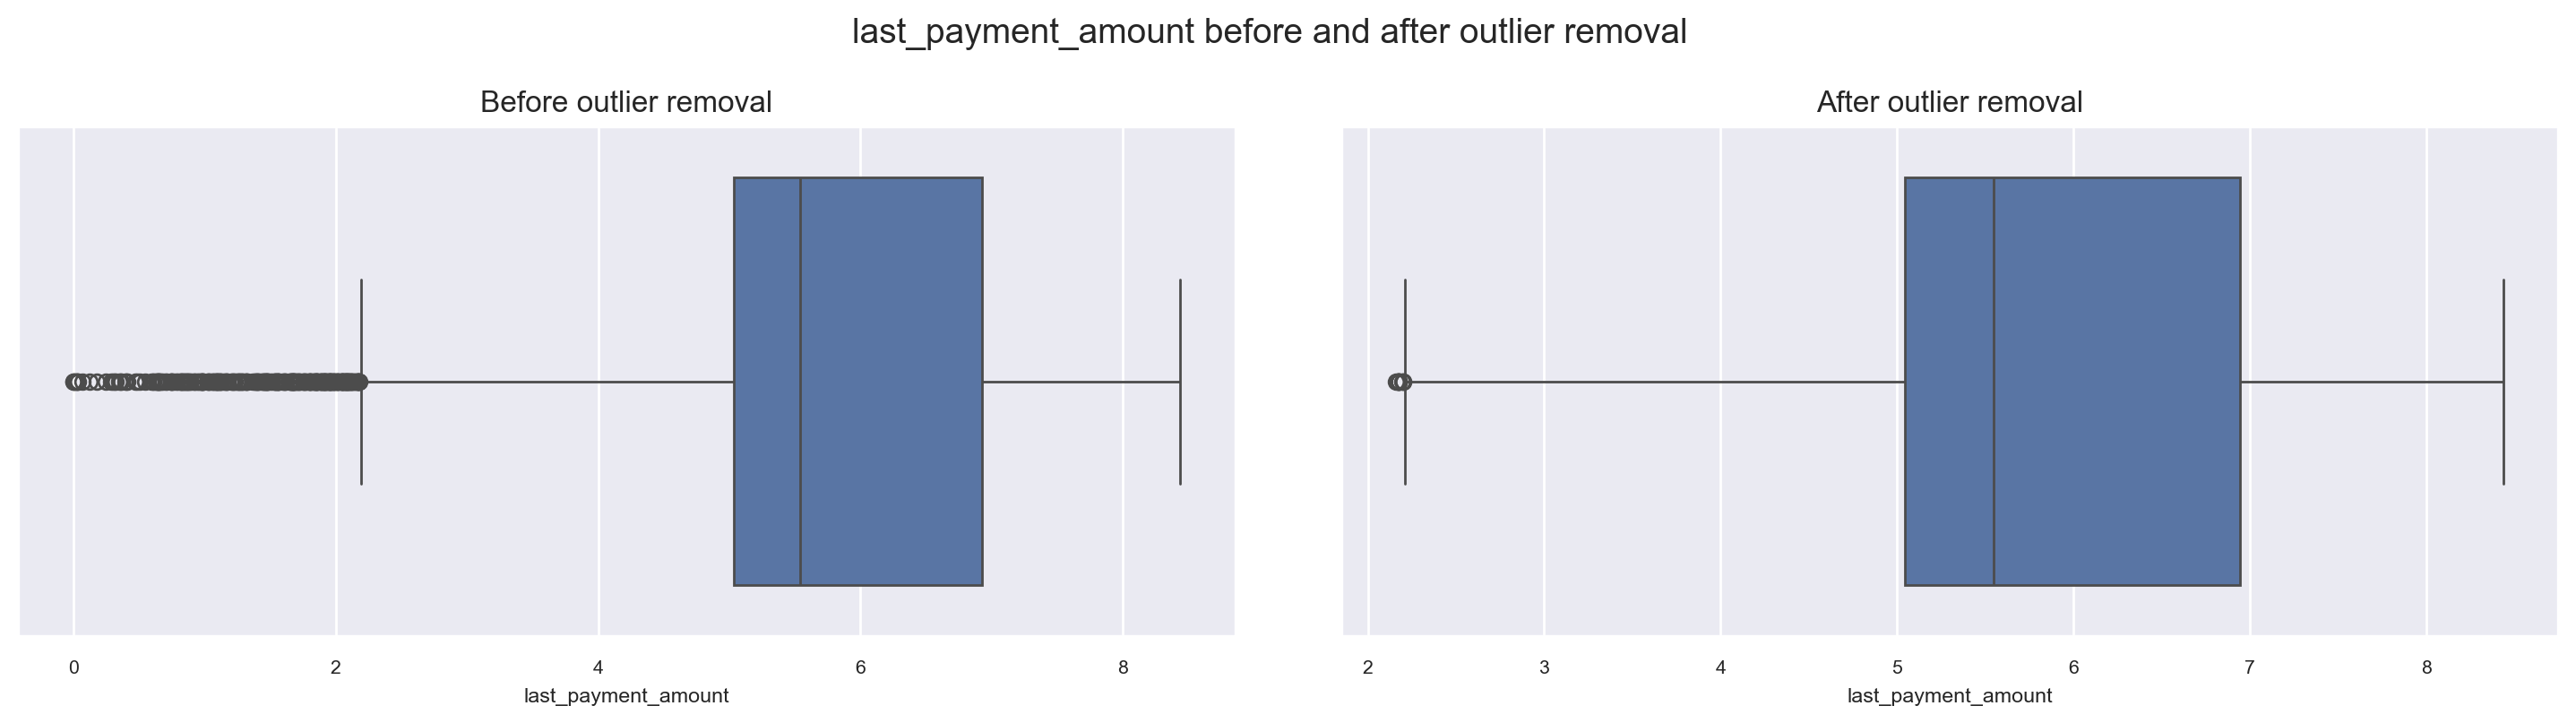

In [97]:
for columns in column_list_numeric:
    plot.plot_outlier_removal_comparison(df_copy, df, columns, title=columns, fig_size=(15,4), padding=2.0)

#### Task 6

We will now check the correlation between columns of the dataframe using a heatmap.

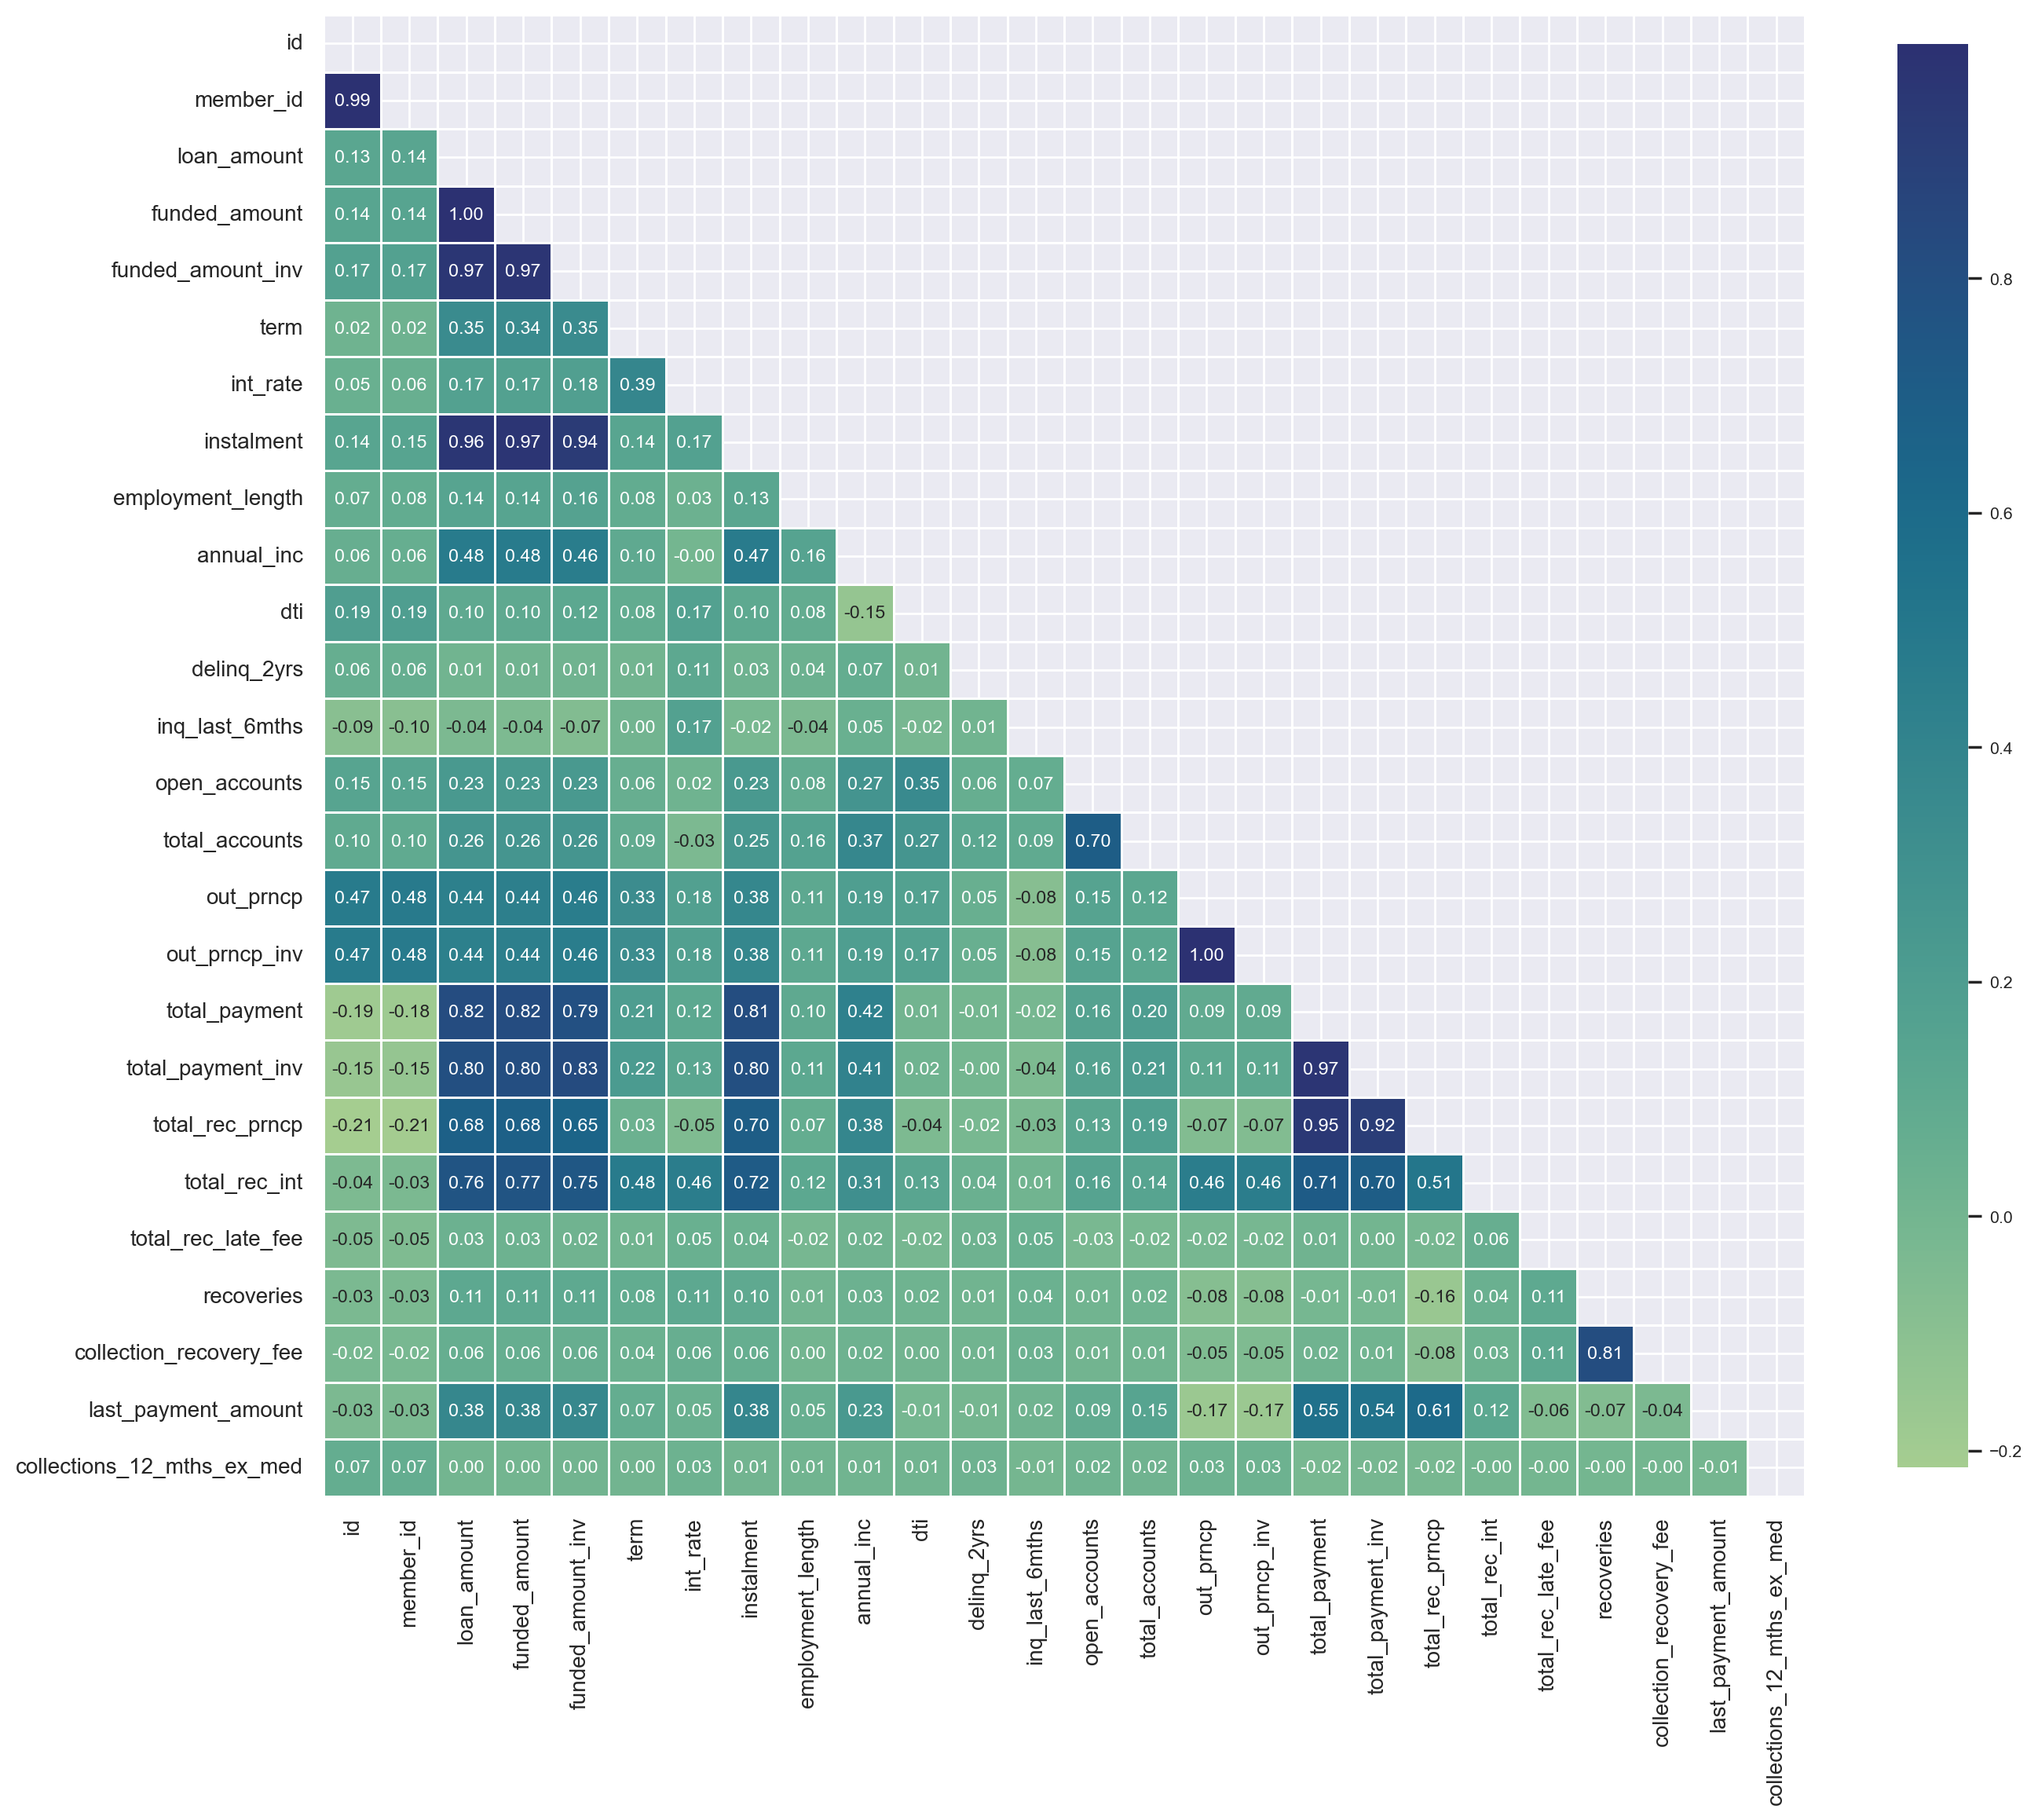

In [98]:
# Get required columns
column_list_corr = transform.get_numeric_columns(df, exclude=['policy_code'])

plot.correlation_heatmap(df, column_list_corr)

There is multicollinearity between 'loan_amount', 'instalment', 'funded_amount' and 'funded_amount_inv' with perfect collinearity between funded_amount and loan_amount. I will drop the 'funded_amount' from this group as perfect colinearity could cause an issue. There is also multicollinearity between 'total_payment_inv', 'total_payment' and 'total_rec_prncp'. Let's calculate VIF values for these columns

In [99]:
## create three models which, in turn, model one of the variables against the other two
total_payment_inv_model = smf.ols("total_payment_inv ~ total_payment + total_rec_prncp", df).fit()
total_payment_model = smf.ols("total_payment ~ total_payment_inv + total_rec_prncp", df).fit()
total_rec_prncp_model = smf.ols("total_rec_prncp ~ total_payment + total_payment_inv", df).fit()

## VIF function
def VIF(r2):
    return 1/(1-r2)

## Work out the VIF scores for each of the models
vif_marks = VIF(total_payment_inv_model.rsquared)
vif_iq = VIF(total_payment_model.rsquared)
vif_sleep = VIF(total_rec_prncp_model.rsquared)

## print the VIF scores
print("VIF scores: \n total_payment_inv_model: {}, \n total_payment_model: {} \n total_rec_prncp_model: {}".format(vif_marks, vif_iq, vif_sleep))

VIF scores: 
 total_payment_inv_model: 17.725415547090762, 
 total_payment_model: 29.01287588977198 
 total_rec_prncp_model: 11.02858799222957


We can see that these score are quite high, idealy a score less than 5 would be desirable. However in this case I will not drop any of these columns until we know what the analysis goal is. We also have perfect linearity between 'out_prncp_inv' and 'out_prncp'. Here I will drop the 'out_prncp_inv' column.

In [100]:
#Drop required columns
column_drop_list = ['funded_amount', 'out_prncp_inv']
df = df_transform.drop_columns(df, column_drop_list)

#Check shape of the dataframe
transform.print_shape(df)

The shape of the dataframe is (52916, 37).


In [101]:
# Save a copy of the transformed dataframe in csv format
#df.to_csv('transformed_loan_data.csv', index_label=False)